# <center> Fall Detection Model

# Contents

### 1. [Business Understanding](#bidness)
### 2. [Data Understanding](#data)
### 3. [Data Preparation](#dataprep)
### 4. [Modeling](#modeling)
> #### [PCA](#pca) | [KMeans clustering](#kmeans) | [Dummy](#dummy) | [Log Reg](#logreg) | [kNN](#knn) | [Tree-based](#tree) | [Stacking Classifier](#sc) | [XG Boost](#xgb)
### 5. [Evaluation](#final)
> #### 5.1 [Alternative Model: 'features' CSV](#feat)
> #### 5.2 [ARCO separate test dataset](#arcotest)
> #### 5.3 [Limitations](#limit)
### 6. [Summary](#summary)

***

# <center> Overview

For my capstone project, I used the __[ARCO Research Dataset for Fall Detection](https://arcoresearch.com/2021/04/16/dataset-for-fall-detection/)__ which includes data from a single motion-sensor worn at waist height and collected from 17 different subjects as they performed both normal daily activities and simulated falls.  After repeated model iterations, I selected the XG Boost classifier algorithm, which was able to correctly predict whether or not a fall had occurred with the highest accuracy & recall, no false negatives, and a very fast prediction time as well.  This model could potentially be used in real-time to quickly alert family members or emergency personnel that a fall has occurred and help minimize injury and cost related to that fall.

![image1](images/fall_image.jpg)

__[from BetterHealthWhileAging.net](https://betterhealthwhileaging.net/wp-content/uploads/2017/07/Depositphotos115426326m-2015-aging-down-in-bathroom-compressor.jpg)__

***

<a id='bidness'></a>
# <center> Business Understanding

![CMS logo](images/CMS_logo.jpeg)

I will be presenting to Allison Oelschlaeger, the Chief Data Officer and Director of the __[Office of Enterprise Data & Analytics (OEDA)](https://www.cms.gov/about-cms/leadership/office-enterprise-data-analytics)__ at the Centers for Medicare and Medicaid Services (CMS) regarding the potential implementation of a fall detection model for elderly Americans at increased risk of falls in their home.  

Falls are the leading cause of fatal and nonfatal injuries among adults aged 65 and older in the United States, per the CDC __[[1]](https://www.cdc.gov/falls/data/index.html)__.  In 2015, about \\$50 billion was spent on medical costs related to non-fatal fall injuries and \\$754 million was spent related to fatal falls __[[2]](https://www.cdc.gov/falls/data/fall-cost.html)__.  As the number of Americans age 65 and older continues to grow, we can reasonably expect the number of falls and injuries related to falls to increase as well.  

![CDC triangles](images/CDC_triangles.jpeg) 

__[from the CDC](https://www.cdc.gov/steadi/pdf/STEADI_ClinicianFactSheet-a.pdf)__

![fall death rates](images/cdc_fall_death_rates.jpg)

__[from the CDC](https://www.cdc.gov/falls/facts.html)__

In addition to the potential injuries related to a fall, there are also social and emotional components to consider.  When a person has experienced a fall, they can develop an increased fear of falling, resulting in a decreased level of activity and social interaction, and therefore a decrease in quality of life __[[3]](https://www.cdc.gov/falls/facts.html)__.  



What role can machine learning play in reducing the impact of falls on the older population?  As a physical therapist who has worked in a variety of settings, I took an interest in an __[article](https://arxiv.org/abs/1707.03502)__ on deep learning and human activity recognition, and wrote a __[blog post](https://medium.com/@jonmccaffrey524/deep-learning-and-human-activity-recognition-98cb43da229)__ to summarize it. The main point, for me, is that there's a wealth of activity data available from our many internet-capable devices (smartphones, smartwatches, etc), but one significant challenge is: how can we process that information in an efficient and meaningful way?  Could this information be utilized in real-time to quickly alert family members or emergency personnel that a fall has occurred and potentially reduce injury and cost related to a fall?  Would such a system allow older adults to safely remain in their own homes for a longer period of time, rather than transitioning to more costly assisted-living environments?

The __[ARCO Research Group](https://arcoresearch.com/)__ has published a __[paper](https://arcoresearch.com/2021/11/23/the-shapes-smart-mirror-approach-for-independent-living-healthy-and-active-ageing/)__ related to a fall monitoring system, and made datasets from their research publicly available, which will be discussed in more detail below.

***

<a id='data'></a>
# <center> Data Understanding

The data I selected for my modeling research comes from the ARCO Research Group in Spain.  It involves activity-monitor recording of 17 participants undergoing a variety of Activity of Daily Living (ADL) tasks as well as simulated falls.  The data was obtained __[here](https://arcoresearch.com/2021/04/16/dataset-for-fall-detection/)__, and downloaded as a .zip file.  The .zip file can also be accessed in the data folder after cloning down the __[GitHub repository](https://github.com/mccafj/Fall_Detection_Model/tree/main/data)__. There is code below to __[unzip](#unzip)__ the folder locally and create dataframes.  The only adjustment needed would be to specify the exact __[filepath](#path)__ to the uncompressed folders on your device after cloning down.  The .gitignore file already lists the uncompressed 'fall-dataset' and 'test_dataset' folders, to avoid pushing the uncompressed files to GitHub.  

The features include detailed sensor information for acceleration (in g, or 9.8m/$s^{2}$), rotation (in deg/sec), and absolute orientation in __[Euler angles](https://en.wikipedia.org/wiki/Euler_angles)__.  The sensor used in the study is a rechargeable __[MetamotionR sensor](https://mbientlab.com/documents/MetaMotionR-PS3.pdf)__ which includes a 3-axis accelerometer, 3-axis gyroscope, and a 3-axis magnetometer.  The absolute orientation of the sensor is calculated by an internal algorithm within the sensor, and expressed in terms of Euler angles (in this case, "roll" (X-axis), "pitch" (Y-axis), and "yaw" (Z-axis).  Below is an image of the sensor and its positioning at waist height on a subject in the study:

![sensor](images/MetamotionR_sensor.jpeg)

There are 3 different folders of CSV files in total.  Included in 2 of the 3 folders is a clear target (0 or 1) indicating if a fall occurred during the recording of the activity.  __[Previous work](https://arcogroup.bitbucket.io/shapes/fall_detection_system/)__ has been done by the authors to create a hybrid algorithm for fall detection, based on a Finite State Machine threshold algorithm, as well as an SVM (Support Vector Machine) machine learning algorithm.  Though I will not be following that hybrid model, I aim to try to replicate their findings while also building my own machine-learning understanding for human activity recognition tasks.  

For more information on the 17 subjects __[[4]](https://arcoresearch.com/2021/04/16/dataset-for-fall-detection/)__:
- they range in age from 22 to 43 years old
- weights range from 56 to 90 kg (123 to 198 lbs)
- and heights range from 1.59 to 1.90m (5'2" to 6'3")

For more information on the 3 separate folders of CSV files:
(text from the website they were downloaded from)

__fall-dataset-features__: "Each row of this dataset contains the features used in our study to filter raw data and describe a movement. Each row represents a complete exericise (Fall or ADL)."

__fall-dataset-raw__: "Raw data from a one second window when the user perfomed the activity. Each row alone is not relevant because it only contains raw data in an instant of time. In order to get relevant information you must use all the data with the same value on the column index, all this data are part of the same exercise along the time."

__fall-dataset-all__: "On these files, all the data collected when the exercises were performed by the users is saved. It could be useful if you need data out of the one second window. This data is not labeled, but you can use fall-dataset-raw in order to find when a fall or an ADLs were produced. Both fall-dataset-raw and fall-dataset-all have timestamp in order to ease this task."

As you will see below, two of the datasets were utilized, but in different manners.  The majority of modeling was done on the data from **fall-dataset-raw**, as it contains non-aggregated information and a target.  The **fall-dataset-features** was used towards the end to simulate a model that would function on more of a time-lapse window (perhaps ~ 10 seconds) and allow for aggregation of data from each window.  In the future, the **fall-dataset-all** could be used by merging it with fall-dataset-raw via the 'Timestamp' column, to create a target but also allow for a look at the least-processed data, perhaps most akin to a real-time input.

The environment utilized for this modeling is outlined in the __[requirements.txt](https://github.com/mccafj/Fall_Detection_Model/blob/main/requirements.txt)__ document.  Using Anaconda, I created a new environment (titled "streamlit_09"), starting with Python initially, and subsequently pip installing streamlit (contains NumPy and Pandas), watchdog, matplotlib, seaborn, jupyter notebook, scikit-learn (contains joblib), and conda installing XG boost.

The entire modeling process was conducted on an HP Pavilion Laptop 15, with Windows 11 Pro version 22H2, a 12th Gen Intel(R) Core(TM) i7-1255U   1.70 GHz, and 16.0 GB RAM.

***

<a id='dataprep'></a>
# <center> Data Preparation

The .zip file contains 3 folders of CSV files of data.  
- The 1st folder (fall-dataset-features) contains 17 CSV files (one for each participant) with all the aggregated features information (25 columns each, 45 rows each) representing summations of each of 45 total tasks, including simulated falls.  These files contain target information to determine whether the task involves a fall or not.     
- The 2nd folder (fall-dataset-raw) contains 17 CSV files with non-aggregated data (11 columns each, ~2900 rows each), summarized/indexed by the task being performed.  This also contains target information to determine whether the task involves a fall or not.
- The 3rd folder (fall-dataset-all) contains 17 CSV files of all the raw data for each participant (10 columns, ~30K rows) NOT summarized / indexed by task.  Though this is the largest source of information, there is no target included in the data.

The data types are all numeric (int or float), though that includes a 'feature' variable that represents each different task / fall, a 'timestamp' variable, and the 0/1 boolean of fall occurrence.  The division between data that represent falls vs. non-fall tasks appears about evenly divided, so there is not a sizable class imbalance.  Also, the amount of data available for each task being performed (45 tasks total), for each participant (17 total), appears roughly equal.  

The libraries I used include Pandas, NumPy, scikit-learn, and matplotlib.  As far as preprocessing, the data is very clean with no nulls.  Pre-processing included PCA and exploratory KMeans clustering to see if any inherent groupings can be discerned.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split, cross_validate, \
cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, silhouette_score, roc_curve, auc, \
RocCurveDisplay, classification_report, ConfusionMatrixDisplay 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from pathlib import Path
import joblib

import xgboost
import time

import warnings
warnings.filterwarnings('ignore')

C:\Users\JonMc\anaconda3\envs\streamlit_09\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<a id='unzip'></a>
## Unzipping fall-dataset.zip

The unzipped files are too large (\~117MB) to push to GitHub, but are saved in the data folder still in their compressed form (\~30MB).

In [2]:
# cd data

In [3]:
# ! unzip fall-dataset.zip

<a id='path'></a>
## Creating a dataframe (df_feat) for fall-dataset-features

Thanks to __[this](https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe#:~:text=Add%20a%20new%20column%20with%20the%20file%20name,new%20column%20with%20a%20generic%20name%20using%20enumerate)__ stackoverflow post on how to combine multiple CSVs into one Pandas dataframe.

In [4]:
# can replace this pathname with the full path to the folder locally
path_feat = r'C:\Users\JonMc\Documents\Flatiron\Fall_Detection_Model\data\fall-dataset\fall-dataset-features' 

# Get the files from the path provided
files_feat = Path(path_feat).glob('*.csv')

In [5]:
# this for loop will create a separate column ('File') based on the filename, to separate subjects if needed

dfs_1 = []
for f in files_feat:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename without the extension
    data['File'] = f.stem
    dfs_1.append(data)

In [6]:
# concatenating all 17 files into one dataframe
df_feat = pd.concat(dfs_1, ignore_index=True)

In [7]:
# sanity check
df_feat.head()

,Index,Acceleration Mean,Rotation Mean,Acceleration Variance,Rotation Variance,Acc Y Mean,Acc Z Mean,Rot Y Mean,Rot Z Mean,Max Acceleration,...,Yaw,Timestamp,Fall,Acc Y Stdev,Acc Z Stdev,Rot Y Stdev,Rot Z Stdev,Fourier Acc Coef,Fourier Rot Coef,File
0,1,1.300608,41.745840,1.274991,148.636248,-0.125055,0.453730,3.412917,1.036585,9.392141,...,358.229492,1612546353614,0,0.483726,1.312748,109.027999,19.364234,92.343149,2963.954659,Subject1
1,2,1.239625,52.031510,1.069585,195.726419,-0.089449,0.413064,6.641859,1.184541,7.485130,...,359.792999,1612546357756,0,0.391341,1.206264,175.210145,6.265235,84.294529,3538.142670,Subject1
2,3,1.529465,89.170260,1.733220,262.935521,-0.087678,0.515523,7.205940,4.921322,11.018893,...,0.008551,1612546361670,0,1.210065,1.427617,154.932945,40.829397,94.826840,5528.556094,Subject1
3,4,1.060228,10.202447,0.237082,39.333528,-0.130035,0.457962,-6.646342,0.395517,2.969044,...,358.421753,1612546366033,0,0.064298,0.280493,35.358783,3.789023,78.456869,754.981105,Subject1
4,5,1.222219,30.061889,1.283746,120.337842,-0.140402,0.477546,-13.010453,0.682056,11.576874,...,357.713165,1612546370850,0,0.250743,1.194289,95.576180,6.248497,85.555305,2104.332225,Subject1


In [8]:
df_feat.head(50)

# demos repeating 'Index' of 45, meaning 45 tasks per subject (indicated by the 'File' column we created)

,Index,Acceleration Mean,Rotation Mean,Acceleration Variance,Rotation Variance,Acc Y Mean,Acc Z Mean,Rot Y Mean,Rot Z Mean,Max Acceleration,...,Yaw,Timestamp,Fall,Acc Y Stdev,Acc Z Stdev,Rot Y Stdev,Rot Z Stdev,Fourier Acc Coef,Fourier Rot Coef,File
0,1,1.300608,41.745840,1.274991,148.636248,-0.125055,0.453730,3.412917,1.036585,9.392141,...,358.229492,1612546353614,0,0.483726,1.312748,109.027999,19.364234,92.343149,2963.954659,Subject1
1,2,1.239625,52.031510,1.069585,195.726419,-0.089449,0.413064,6.641859,1.184541,7.485130,...,359.792999,1612546357756,0,0.391341,1.206264,175.210145,6.265235,84.294529,3538.142670,Subject1
2,3,1.529465,89.170260,1.733220,262.935521,-0.087678,0.515523,7.205940,4.921322,11.018893,...,0.008551,1612546361670,0,1.210065,1.427617,154.932945,40.829397,94.826840,5528.556094,Subject1
3,4,1.060228,10.202447,0.237082,39.333528,-0.130035,0.457962,-6.646342,0.395517,2.969044,...,358.421753,1612546366033,0,0.064298,0.280493,35.358783,3.789023,78.456869,754.981105,Subject1
4,5,1.222219,30.061889,1.283746,120.337842,-0.140402,0.477546,-13.010453,0.682056,11.576874,...,357.713165,1612546370850,0,0.250743,1.194289,95.576180,6.248497,85.555305,2104.332225,Subject1
5,6,1.586209,67.890393,2.247315,114.878237,-0.179645,0.559630,2.859436,-2.373770,14.055819,...,357.156738,1612546396631,0,0.639304,1.327880,110.568531,36.473423,90.413899,3869.752428,Subject1
6,7,1.512595,81.585007,1.620114,119.763670,-0.133317,0.639488,-12.511995,-7.885846,10.525451,...,350.824646,1612546401765,0,0.846939,1.248835,84.071822,33.797201,92.268325,4976.685438,Subject1
7,8,1.340308,57.541038,1.445330,94.965213,-0.235703,0.578407,5.504955,0.401105,10.616751,...,354.565460,1612546407119,0,0.439014,0.708348,90.423817,14.957783,85.779725,3682.626427,Subject1
8,9,1.375997,95.503753,1.227727,153.677428,-0.089980,0.435035,13.422632,-2.480008,7.254419,...,343.955811,1612546412113,0,0.744411,1.305662,117.593817,46.316231,83.935810,5825.728905,Subject1
9,10,1.151627,111.083964,1.445851,97.440283,-0.073564,0.394385,-22.507318,-2.796342,7.307068,...,341.684204,1612546416437,0,0.471556,1.210703,111.013056,32.379890,57.581350,5554.198210,Subject1


This dataframe contains aggregated information which may be more appropriate for a time-lapse evaluation for fall detection, rather than real-time input.  Since this dataframe does contain the target of 'Fall', we will use it in alternative form of  modeling later in this notebook.

### Initial EDA for df_feat

In [9]:
df_feat.shape

# total rows = 765 (45 tasks x 17 subjects)

(765, 26)

In [10]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index                  765 non-null    int64  
 1   Acceleration Mean      765 non-null    float64
 2   Rotation Mean          765 non-null    float64
 3   Acceleration Variance  765 non-null    float64
 4   Rotation Variance      765 non-null    float64
 5   Acc Y Mean             765 non-null    float64
 6   Acc Z Mean             765 non-null    float64
 7   Rot Y Mean             765 non-null    float64
 8   Rot Z Mean             765 non-null    float64
 9   Max Acceleration       765 non-null    float64
 10  Max Rotation           765 non-null    float64
 11  First Acceleration     765 non-null    float64
 12  Last Acceleration      765 non-null    float64
 13  Fall Time              765 non-null    int64  
 14  Pitch                  765 non-null    float64
 15  Roll  

In [11]:
df_feat.describe()

,Index,Acceleration Mean,Rotation Mean,Acceleration Variance,Rotation Variance,Acc Y Mean,Acc Z Mean,Rot Y Mean,Rot Z Mean,Max Acceleration,...,Roll,Yaw,Timestamp,Fall,Acc Y Stdev,Acc Z Stdev,Rot Y Stdev,Rot Z Stdev,Fourier Acc Coef,Fourier Rot Coef
count,765.00000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,...,765.000000,765.000000,7.650000e+02,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,23.00000,1.291181,91.264983,1.021121,114.649928,-0.065314,0.160678,1.521893,5.011623,6.687504,...,35.117611,211.507451,1.613418e+12,0.437908,0.514702,0.727502,107.458123,50.464953,83.186551,5740.832684
std,12.99567,0.196225,51.953837,0.536389,75.321626,0.495275,0.535250,33.470903,29.496195,3.536698,...,40.464925,132.904788,1.816585e+09,0.496454,0.370574,0.433159,70.714445,34.752515,18.708207,3260.002571
min,1.00000,0.852751,4.126064,0.174386,15.431657,-1.333600,-1.361850,-149.817077,-115.042328,1.844608,...,-66.699471,0.008551,1.608032e+12,0.000000,0.009248,0.057813,10.448235,1.059858,9.258738,272.320192
25%,12.00000,1.146914,47.920742,0.620723,62.434765,-0.363540,-0.106187,-12.703253,-4.886760,4.008378,...,-0.795930,80.633316,1.612546e+12,0.000000,0.233469,0.416951,57.042946,20.353484,72.776846,2963.925784
50%,23.00000,1.241952,90.161143,0.908397,97.786643,-0.051208,0.196339,1.879158,1.897280,5.724824,...,38.712997,245.695786,1.613472e+12,0.000000,0.424046,0.633626,90.829730,44.590093,81.318565,5690.806673
75%,34.00000,1.394088,125.834012,1.303673,139.346576,0.244643,0.575195,18.925449,15.962060,8.448593,...,74.385406,340.452087,1.614937e+12,1.000000,0.688784,0.927536,134.929506,74.999191,93.476663,7838.591800
max,45.00000,2.288287,305.700631,3.335482,525.954520,1.134824,1.211130,111.674966,141.338815,21.817957,...,88.928444,359.993896,1.615570e+12,1.000000,2.218621,2.507445,402.570204,165.500142,168.842018,20555.704507


In [12]:
df_feat['Fall'].value_counts()

0    430
1    335
Name: Fall, dtype: int64

In [13]:
df_feat['File'].value_counts()

Subject1     45
Subject2     45
Subject8     45
Subject7     45
Subject6     45
Subject5     45
Subject4     45
Subject3     45
Subject17    45
Subject10    45
Subject16    45
Subject15    45
Subject14    45
Subject13    45
Subject12    45
Subject11    45
Subject9     45
Name: File, dtype: int64

## Creating a dataframe (df_raw) for fall-dataset-raw

In [14]:
# can replace this pathname with the full path to the folder locally
path_raw = r'C:\Users\JonMc\Documents\Flatiron\Fall_Detection_Model\data\fall-dataset\fall-dataset-raw' 

# Get the files from the path provided
files_raw = Path(path_raw).glob('*.csv') 

In [15]:
# this for loop will create a separate column ('File') based on the filename, to separate subjects if needed
dfs_2 = []
for f in files_raw:
    data = pd.read_csv(f)
    data['File'] = f.stem
    dfs_2.append(data)

In [16]:
# concatenating all 17 files into one dataframe
df_raw = pd.concat(dfs_2, ignore_index=True)

In [17]:
# sanity check
df_raw.head()

,Feature Line,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp,Fall,File
0,1,3.191406,0.768555,8.799805,98.841469,-488.109772,-94.939026,8.554567,68.015976,354.055115,1612546353614,0,Subject1-raw
1,1,2.965820,0.224121,2.638672,-261.890259,-15.853659,-24.634148,7.382404,72.709183,353.782318,1612546353616,0,Subject1-raw
2,1,0.854980,0.500000,0.548828,-337.865875,535.853699,49.817074,7.836745,72.958641,355.967834,1612546353657,0,Subject1-raw
3,1,-1.238770,-2.900391,-6.257324,-254.207321,460.792694,49.817074,10.936003,65.359154,0.667080,1612546353659,0,Subject1-raw
4,1,1.804688,2.567871,-0.529297,741.890259,-307.500000,107.073174,26.398607,61.147324,2.398508,1612546353661,0,Subject1-raw


This dataframe contains multiple features of sensor input, in a non-aggregated fashion, and has a target ('Fall') that could be used for supervised learning.

In [18]:
# example of a specific 'Feature Line' (in this case #34) being related to a fall ('Fall' is 1 for all rows)
df_raw.loc[df_raw['Feature Line'] == 34]

,Feature Line,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp,Fall,File
2061,34,1.830078,-3.086426,0.769043,-482.073181,66.402443,20.853659,-3.070647,37.349861,294.698303,1612546973348,1,Subject1-raw
2062,34,0.355957,-2.150391,0.386719,-397.256104,260.548798,235.853668,9.261047,27.617056,298.874664,1612546973350,1,Subject1-raw
2063,34,-0.520508,-0.357422,0.922363,-248.109756,-209.268295,89.207321,9.261047,27.617056,298.874664,1612546973351,1,Subject1-raw
2064,34,2.211426,-4.152832,4.838867,-86.890244,-369.817078,-221.463425,40.616371,18.962431,286.442017,1612546973437,1,Subject1-raw
2065,34,5.927734,-6.823242,1.008789,-207.560974,-229.451218,-303.963409,51.747276,27.424732,283.300171,1612546973481,1,Subject1-raw
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48975,34,-0.273926,-1.191895,0.081055,5.060976,17.682928,-47.195122,83.912910,-16.558981,312.468414,1615568517481,1,Subject9-raw
48976,34,-0.233887,-0.982422,0.109375,-2.134146,8.841464,-48.292683,83.912910,-16.558981,312.468414,1615568517482,1,Subject9-raw
48977,34,-0.011230,-1.018555,-0.014648,-40.731709,-14.085366,-41.341465,84.714806,-13.305731,315.865173,1615568517484,1,Subject9-raw
48978,34,0.066895,-0.602051,-0.152344,-40.121952,1.951220,-37.500000,85.086861,-12.893793,316.383667,1615568517486,1,Subject9-raw


### initial exploratory data analysis (EDA) for df_raw

In [19]:
df_raw.shape

(49713, 13)

In [20]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49713 entries, 0 to 49712
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Feature Line  49713 non-null  int64  
 1   Acc(X)        49713 non-null  float64
 2   Acc(Y)        49713 non-null  float64
 3   Acc(Z)        49713 non-null  float64
 4   Rot(X)        49713 non-null  float64
 5   Rot(Y)        49713 non-null  float64
 6   Rot(Z)        49713 non-null  float64
 7   Pitch         49713 non-null  float64
 8   Roll          49713 non-null  float64
 9   Yaw           49713 non-null  float64
 10  Timestamp     49713 non-null  int64  
 11  Fall          49713 non-null  int64  
 12  File          49713 non-null  object 
dtypes: float64(9), int64(3), object(1)
memory usage: 4.9+ MB


In [21]:
df_raw.describe()

,Feature Line,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp,Fall
count,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,49713.000000,4.971300e+04,49713.000000
mean,22.405749,0.526012,-0.048381,0.168381,1.511753,1.841931,4.038409,-1.624746,39.261181,202.300937,1.613400e+12,0.409088
std,12.956872,1.045556,0.781739,0.976210,84.624702,132.618225,65.596113,81.993075,39.422234,136.156753,1.865655e+09,0.491671
min,1.000000,-14.330566,-15.739258,-15.999512,-1997.987793,-1997.987793,-768.475647,-179.998138,-87.712242,0.000990,1.608032e+12,0.000000
25%,11.000000,-0.100098,-0.340332,-0.117676,-13.719513,-16.036585,-8.231708,-30.365431,3.811717,58.089073,1.612546e+12,0.000000
50%,22.000000,0.595215,-0.055176,0.179199,0.548781,-0.426829,0.609756,2.950168,53.229465,212.538193,1.613472e+12,0.000000
75%,34.000000,0.984863,0.239746,0.534180,16.951220,19.573172,15.060976,28.444160,74.810349,339.976105,1.614937e+12,1.000000
max,45.000000,15.999512,13.734863,14.244141,1997.987793,1844.207397,1172.012207,179.996017,89.847931,359.997375,1.615570e+12,1.000000


In [22]:
# value counts per subject
df_raw['File'].value_counts()

Subject15-raw    3370
Subject9-raw     3166
Subject2-raw     3150
Subject3-raw     3109
Subject8-raw     3019
Subject13-raw    2935
Subject10-raw    2924
Subject5-raw     2899
Subject14-raw    2897
Subject7-raw     2896
Subject11-raw    2872
Subject17-raw    2847
Subject6-raw     2837
Subject4-raw     2770
Subject1-raw     2755
Subject16-raw    2722
Subject12-raw    2545
Name: File, dtype: int64

In [23]:
# no nulls
df_raw.isna().sum()

Feature Line    0
Acc(X)          0
Acc(Y)          0
Acc(Z)          0
Rot(X)          0
Rot(Y)          0
Rot(Z)          0
Pitch           0
Roll            0
Yaw             0
Timestamp       0
Fall            0
File            0
dtype: int64

## Creating a dataframe (df_all) for fall-dataset-all

In [24]:
# can replace this pathname with the full path to the folder locally
path_all = r'C:\Users\JonMc\Documents\Flatiron\Fall_Detection_Model\data\fall-dataset\fall-dataset-all' 

# Get the files from the path provided
files_all = Path(path_all).glob('*.csv')

In [25]:
# this for loop will create a separate column based on the filename, to separate subjects if needed

dfs_3 = []
for f in files_all:
    data = pd.read_csv(f)
    data['File'] = f.stem
    dfs_3.append(data)

In [26]:
# concatenating all 17 files into one dataframe
df_all = pd.concat(dfs_3, ignore_index=True)

In [27]:
# sanity check
df_all.head()

,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp,File
0,0.932617,-0.166504,0.411133,3.231707,-2.865854,3.536585,9.411585,64.421898,359.941193,1612546351138,Subject1-raw-all
1,0.934570,-0.166016,0.398926,3.109756,-1.280488,3.353659,9.430594,64.434891,359.882324,1612546351140,Subject1-raw-all
2,0.938477,-0.170410,0.387207,2.317073,-0.609756,2.987805,9.448231,64.434715,359.828003,1612546351141,Subject1-raw-all
3,0.937988,-0.176270,0.380371,2.195122,-0.731707,2.621951,9.465791,64.432030,359.783264,1612546351182,Subject1-raw-all
4,0.937012,-0.173340,0.384766,2.195122,-1.463415,2.256098,9.481668,64.436104,359.742218,1612546351184,Subject1-raw-all


This dataframe contains unprocessed sensor input, but unfortunately, on its own, it has no target or means to identify what task is being performed.  As this is a supervised learning task, we will not be using this dataframe in our initial modeling, but could make use of it in the future, perhaps by joining on 'Timestamp' from df_raw

### Initial EDA for df_all

In [28]:
df_all.shape

(678715, 11)

In [29]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678715 entries, 0 to 678714
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Acc(X)     678715 non-null  float64
 1   Acc(Y)     678715 non-null  float64
 2   Acc(Z)     678715 non-null  float64
 3   Rot(X)     678715 non-null  float64
 4   Rot(Y)     678715 non-null  float64
 5   Rot(Z)     678715 non-null  float64
 6   Pitch      678715 non-null  float64
 7   Roll       678715 non-null  float64
 8   Yaw        678715 non-null  float64
 9   Timestamp  678715 non-null  int64  
 10  File       678715 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 57.0+ MB


In [30]:
df_all.describe()

,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp
count,678715.000000,678715.000000,678715.000000,678715.000000,678715.000000,678715.000000,678715.000000,678715.000000,678715.000000,6.787150e+05
mean,0.719117,-0.037409,0.194582,0.332711,-0.220278,0.391412,-8.048431,53.698468,208.737719,1.613281e+12
std,0.522161,0.411668,0.480294,39.153883,48.799114,27.166656,83.289489,32.290934,134.460734,1.891624e+09
min,-14.330566,-15.739258,-15.999512,-1997.987793,-1997.987793,-768.475647,-179.998886,-87.712242,-0.000000,1.608032e+12
25%,0.580078,-0.250488,-0.009766,-5.487805,-4.878049,-2.743902,-18.488931,41.500603,70.778984,1.611079e+12
50%,0.907227,-0.034180,0.196777,0.548781,-0.365854,0.365854,2.222400,64.662773,239.999176,1.613472e+12
75%,0.994629,0.158691,0.447266,6.463415,3.475610,3.353659,24.504577,77.857861,341.061996,1.614937e+12
max,15.999512,13.734863,14.244141,1997.987793,1844.207397,1172.012207,179.999420,89.991936,359.999176,1.615570e+12


In [31]:
df_all['File'].value_counts()

Subject15-raw-all    75650
Subject2-raw-all     57617
Subject8-raw-all     53069
Subject14-raw-all    47176
Subject9-raw-all     43937
Subject7-raw-all     43639
Subject10-raw-all    39043
Subject17-raw-all    38285
Subject12-raw-all    37134
Subject3-raw-all     34303
Subject4-raw-all     34194
Subject5-raw-all     32879
Subject13-raw-all    32634
Subject11-raw-all    29949
Subject1-raw-all     29551
Subject6-raw-all     25949
Subject16-raw-all    23706
Name: File, dtype: int64

In [32]:
df_all.isna().sum()

Acc(X)       0
Acc(Y)       0
Acc(Z)       0
Rot(X)       0
Rot(Y)       0
Rot(Z)       0
Pitch        0
Roll         0
Yaw          0
Timestamp    0
File         0
dtype: int64

## Data Preparation for Modeling 
#### using df_raw dataframe

To review, df_raw does have a target, but also more individual data points to consider rather than summary statistics.  This allows for more granularity (1 second intervals).  

Our first dataframe above (df_feat) is the summary of each task per individual (45 tasks x 17 individuals).  It has summary info of the main numeric categories, including mean, variance, coefficients, and standard deviation.  We will use this data towards the end of the notebook for an alternative modeling concept.

Our third and last dataframe above (df_all) is *ALL* the raw data with no target. Though we couldn't use this data in a supervised learning model on its own, it may be possible to combine it with df_raw in the future (via "Timestamp") for another alternative modeling concept with true 'real-time' unprocessed data.

In [33]:
# review of df_raw features

df_raw.head()

,Feature Line,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw,Timestamp,Fall,File
0,1,3.191406,0.768555,8.799805,98.841469,-488.109772,-94.939026,8.554567,68.015976,354.055115,1612546353614,0,Subject1-raw
1,1,2.965820,0.224121,2.638672,-261.890259,-15.853659,-24.634148,7.382404,72.709183,353.782318,1612546353616,0,Subject1-raw
2,1,0.854980,0.500000,0.548828,-337.865875,535.853699,49.817074,7.836745,72.958641,355.967834,1612546353657,0,Subject1-raw
3,1,-1.238770,-2.900391,-6.257324,-254.207321,460.792694,49.817074,10.936003,65.359154,0.667080,1612546353659,0,Subject1-raw
4,1,1.804688,2.567871,-0.529297,741.890259,-307.500000,107.073174,26.398607,61.147324,2.398508,1612546353661,0,Subject1-raw


In [34]:
# making a copy of df-raw to use for modeling
df = df_raw.copy()
df.shape

(49713, 13)

Our first step in preparation for modeling is to remove 'Timestamp' from the dataframe.  Though it is a numeric value that could be processed in our machine learning algorithms, the feature of time has no direct impact on the determination of fall vs. no fall in this research dataset.

In [35]:
# dropping 'Timestamp'
df.drop(['Timestamp'], axis=1, inplace=True)

In [36]:
# sanity check
df.shape

(49713, 12)

We will also remove 'Feature Line' as well since that directly indicates the type of activity being performed, and therefore whether or not it is a simulated fall or an ADL task.  This is in consideration of the fact that the *type* of activity being performed would not be known outside of a controlled experimental environment.

In [37]:
# looking at correlation of features.  Note 'Feature Line' has highest positive correlation to 'Fall'
df.corr()['Fall']

Feature Line    0.852675
Acc(X)         -0.444877
Acc(Y)          0.035396
Acc(Z)         -0.096861
Rot(X)         -0.042177
Rot(Y)          0.027612
Rot(Z)         -0.015038
Pitch          -0.111226
Roll           -0.794995
Yaw            -0.151548
Fall            1.000000
Name: Fall, dtype: float64

In [38]:
# dropping 'Feature Line'
df.drop(['Feature Line'], axis=1, inplace=True)

In [39]:
# sanity check again
df.shape

(49713, 11)

We will keep 'File', and treat it as a categorical variable. The 'File' column will allow us to differentiate one individual from another, which may be beneficial for considering outliers, or just in consideration of the fact that each monitoring system could be 'individualized' in the future, or could perhaps 'learn' an individual's behavior?  

The feature 'Fall' is our target, and will be separated at the train-test split.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49713 entries, 0 to 49712
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Acc(X)  49713 non-null  float64
 1   Acc(Y)  49713 non-null  float64
 2   Acc(Z)  49713 non-null  float64
 3   Rot(X)  49713 non-null  float64
 4   Rot(Y)  49713 non-null  float64
 5   Rot(Z)  49713 non-null  float64
 6   Pitch   49713 non-null  float64
 7   Roll    49713 non-null  float64
 8   Yaw     49713 non-null  float64
 9   Fall    49713 non-null  int64  
 10  File    49713 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 4.2+ MB


***

<a id='modeling'></a>
# <center> Modeling

Modeling will involve the use of a train-test split, a baseline dummy classifier, then pipelines, ColumnTransformer and cross-validation for multiple models.  The metrics used in cross-validation of this binary classification problem include accuracy, recall, precision, and F1 score.  Models will also be evaluated via confusion matrix and ROC curve / AUC score.  The progression of models involves: logistic regression, k Nearest Neighbors, Decision Trees, Random Forest, Grid searches (for kNN and RFC), a Stacking Classifier, Gradient Boosting, and XG boosting.  My target variable from the chosen dataframe is 'Fall', which contains a boolean of 0 or 1 for whether a fall occurred in that segment of testing.

## Pre-processing for df_raw

Train-test split (default 75/25), pipelines with StandardScaler and One Hot Encoding.  Also performed separate PCA and exploratory KMeans clustering 

### Train-test split

In [41]:
# using 'Fall' as target (y), therefore dropping it from X
X = df.drop(['Fall'], axis=1)
y = df['Fall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [42]:
# sanity check
X_train.shape

(37284, 10)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37284 entries, 8308 to 45474
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Acc(X)  37284 non-null  float64
 1   Acc(Y)  37284 non-null  float64
 2   Acc(Z)  37284 non-null  float64
 3   Rot(X)  37284 non-null  float64
 4   Rot(Y)  37284 non-null  float64
 5   Rot(Z)  37284 non-null  float64
 6   Pitch   37284 non-null  float64
 7   Roll    37284 non-null  float64
 8   Yaw     37284 non-null  float64
 9   File    37284 non-null  object 
dtypes: float64(9), object(1)
memory usage: 3.1+ MB


In [44]:
# checking that length of y_train matches X_train
y_train.shape

(37284,)

### Pipelines and ColumnTransformer

I'll create pipelines and ColumnTransformer now for later modeling.

In [45]:
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [46]:
# by including only 'float64' in num_feats, that leaves out 'File', which is 'object' type
num_feats = list(X_train.select_dtypes(include=['float64']).columns)
cat_feats = ['File']

In [47]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, num_feats),
                                     ('subpipe_cat', subpipe_cat, cat_feats)],
                                     remainder='passthrough')

<a id='pca'></a>
## Unsupervised exploratory analysis with PCA and KMeans Clustering

Since we are not concerned with multicollinearity or separating targets, we can include ALL aspects of df_raw

In [48]:
# instantiating PCA.  Will keep to n_components=2 to visualize via scatter plot
pca = PCA(n_components=2, random_state=24)

In [49]:
# instantiating StandardScaler
scaler = StandardScaler()

# creating an array for PCA
PCA_array = scaler.fit_transform(df_raw.drop(['File'], axis=1))
PCA_array

# removed 'File' to avoid sparse matrix, and having to use TruncatedSVD

array([[-1.65209356,  2.54928604,  1.04503331, ...,  1.11456612,
        -0.45761757, -0.83204557],
       [-1.65209356,  2.33352697,  0.34858755, ...,  1.11256256,
        -0.45761757, -0.83204557],
       [-1.65209356,  0.31463852,  0.70149504, ...,  1.12861419,
        -0.45761755, -0.83204557],
       ...,
       [ 1.74382202, -0.2691252 , -0.15984909, ..., -0.28216674,
         1.1624988 ,  1.20185724],
       [ 1.74382202, -0.4265079 , -0.12799373, ..., -0.28150038,
         1.1624988 ,  1.20185724],
       [ 1.74382202, -0.45919867, -0.0730276 , ..., -0.28140154,
         1.16249885,  1.20185724]])

In [50]:
# fit & transform PCA
X_pca = pca.fit_transform(PCA_array)

In [51]:
X_pca.shape

(49713, 2)

In [52]:
pca.explained_variance_ratio_

array([0.25231752, 0.1388462 ])

Unfortunately the top 2 components only explain about 39% of the variance, likely limiting the benefit of this analysis.  

<a id='kmeans'></a>
## KMeans Clustering
Thanks to __[this](https://www.askpython.com/python/examples/plot-k-means-clusters-python)__ askpython tutorial for the plotting functions below.

In [53]:
# commented out as it took ~15 mins to run the first time

# this code from Flatiron lecture

# silhouette_scores = []
# for k in range (2, 20):
#     clusters = KMeans(n_clusters=k, n_init=10, random_state=24)
#     cluster_labels = clusters.fit_predict(X_pca)
#     silhouette = metrics.silhouette_score(X_pca, cluster_labels)
#     silhouette_scores.append(silhouette)

In [54]:
# silhouette_scores

# k=3 had the highest value (0.5862170619496886)

In [55]:
# instantiating KMeans, using n_clusters = 3
kmeans = KMeans(n_clusters=3, n_init=10, random_state=24)

In [56]:
# creating labels based on n_clusters=3
label = kmeans.fit_predict(X_pca)
print(label)

[1 1 1 ... 2 2 2]


In [57]:
#filter rows of original data
filtered_label0 = X_pca[label == 0]
filtered_label0

array([[-1.63606302, -7.15481281],
       [ 0.50089255, -0.21433753],
       [ 0.49722134, -0.24755651],
       ...,
       [ 2.19753112, -0.35533672],
       [ 2.03708229, -0.30014062],
       [ 2.04838143, -0.15398816]])

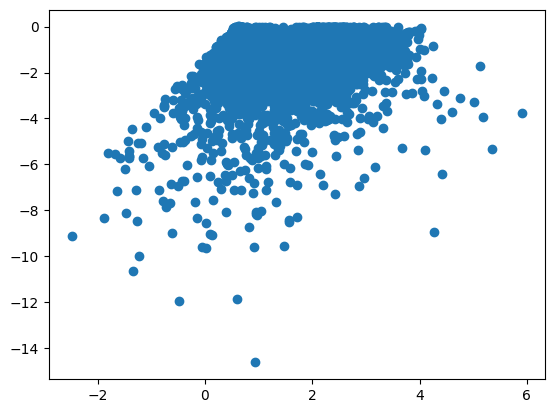

In [58]:
#plotting the results for one label (0)
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

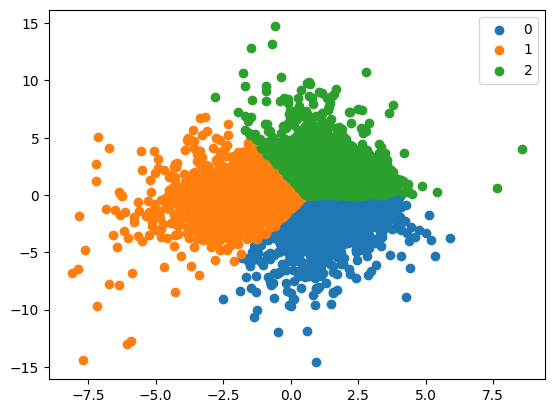

In [59]:
#Getting unique labels and plotting all
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = i)
plt.legend()
plt.show();

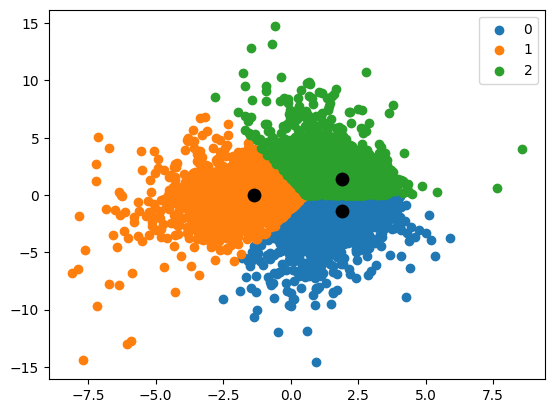

In [60]:
# Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.savefig('images/kmeans_clusters.png', bbox_inches='tight', dpi=300)
plt.show();

PCA and KMeans clustering did not reveal any significant separation among clusters, based on n_components = 2 to maintain the ability to visualize the data.  This may be because only 39% of the variance is explained by limiting it to 2 components.  

## Functions used repeatedly during df_raw modeling

Thanks to __[this](https://stackoverflow.com/questions/61076008/confusion-matrix-colors-match-data-size-and-not-classification-accuracy)__ stackoverflow post for labeling confusion matrices in function below.

In [61]:
def conf_matrix(y_pred):
    """
    creating a function for plotting confusion matrix and 
    printing classification report for each model used on df_raw
    
    """
    target_names = ['No Fall', 'Fall']
    labels_names = [0,1] 
    cm = confusion_matrix(y_train, y_pred, labels=labels_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()
    print('*************************************************************************************')
    print(classification_report(y_train, y_pred, labels=labels_names, target_names=target_names))    

In [62]:
def roc(y_pred):
    """
    creating a function for roc curve for each model used on df_raw
    
    """
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()

In [63]:
class results:
    
    def __init__(self, data):
        """
        creating a class object and function for 
        saving off cross_validate scores
        
        """
        self._train_accuracy = data['train_accuracy'].mean()
        self._test_accuracy = data['test_accuracy'].mean()
        self._train_recall = data['train_recall'].mean()
        self._test_recall = data['test_recall'].mean()
        self._train_precision = data['train_precision'].mean()
        self._test_precision = data['test_precision'].mean()
        self._train_f1 = data['train_f1'].mean()
        self._test_f1 = data['test_f1'].mean()
        self._fit_time = data['fit_time'].mean()
        self._score_time = data['score_time'].mean()

In [64]:
def print_results(model):
    """
    creating a function for printing out the cross_validate scores, 
    rounded for readability
    
    """
    print(f"""
    The mean train accuracy score is {(round(model._train_accuracy, 4))}.
    The mean test accuracy score is {(round(model._test_accuracy, 4))}. \n
    The mean train recall score is {(round(model._train_recall, 4))}.
    The mean test recall score is {(round(model._test_recall, 4))}. \n
    The mean train precision score is {(round(model._train_precision, 4))}.
    The mean test precision score is {(round(model._test_precision, 4))}. \n
    The mean train f1 score is {(round(model._train_f1, 4))}.
    The mean test f1 score is {(round(model._test_f1, 4))}. \n
    **********************************
    The mean fit time for this model is {(round(model._fit_time, 4))} seconds.
    The mean score time for this model is {(round(model._score_time, 4))} seconds.
    """)

<a id='dummy'></a>
## DummyClassifier

Creating a dummy model that will return the most common target

In [65]:
y_train.value_counts(normalize=True)

# Note '0' is 59% of the total values

0    0.593204
1    0.406796
Name: Fall, dtype: float64

In [66]:
# instantiating
dummy_model = DummyClassifier(strategy='most_frequent')

In [67]:
# excluding 'File', as it's not needed for the dummy model
X_tr_num= X_train.select_dtypes(include='float64')
X_tr_num

,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Pitch,Roll,Yaw
8308,-0.720703,0.235840,0.743652,-27.134148,16.097561,-12.134147,2.906763,-29.597702,357.378632
11906,1.043457,0.102051,-0.009766,13.658537,-16.463415,-3.841464,-5.234757,84.123871,159.863800
47091,0.028809,0.015137,0.025391,-18.658537,-0.914634,-7.195122,-0.162081,87.287392,348.663452
18432,0.941406,-0.225098,-0.270996,-0.243902,3.475610,0.000000,166.721191,69.375359,356.566071
1839,0.328125,0.518555,-0.862793,13.658537,-18.170732,-0.731707,-148.492294,17.812698,328.536987
...,...,...,...,...,...,...,...,...,...
21633,1.001465,0.077148,0.187012,0.853659,-0.304878,0.914634,-3.804095,78.679192,357.936279
19857,0.221191,0.799316,-0.207031,-32.317074,-103.109756,-38.292683,-107.715790,23.008615,72.689850
14528,-0.090332,0.079102,-0.065430,35.609756,-10.060976,11.890244,-19.649218,68.691734,348.832550
899,1.004395,-0.085449,0.307129,-70.060974,-2.012195,-57.073174,15.132795,42.851158,88.206261


In [68]:
# fitting
dummy_model.fit(X_tr_num, y_train)

DummyClassifier(strategy='most_frequent')

In [69]:
# predicting
dummy_pred = dummy_model.predict(X_tr_num)
dummy_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

This model will predict all zeros (no falls) since that is the "most frequent" count in y_train ('Fall')

In [70]:
# getting mean of accuracy scores in cross-validation
dummy_cv = cross_val_score(dummy_model, X_tr_num, y_train, cv=5)
dummy_cv.mean()

# 59.3% accurate

0.5932035192039511

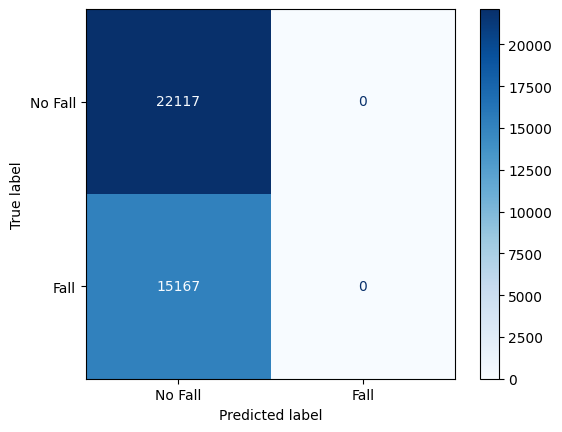

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       0.59      1.00      0.74     22117
        Fall       0.00      0.00      0.00     15167

    accuracy                           0.59     37284
   macro avg       0.30      0.50      0.37     37284
weighted avg       0.35      0.59      0.44     37284



In [71]:
# confusion matrix for dummy model
conf_matrix(dummy_pred)

In [72]:
# double-checking number of false negatives in dummy model (or the number of actual falls that occurred)

(1 - dummy_cv.mean()) * len(X_tr_num)

15166.999989999887

In [73]:
y_train.value_counts(normalize=False)

0    22117
1    15167
Name: Fall, dtype: int64

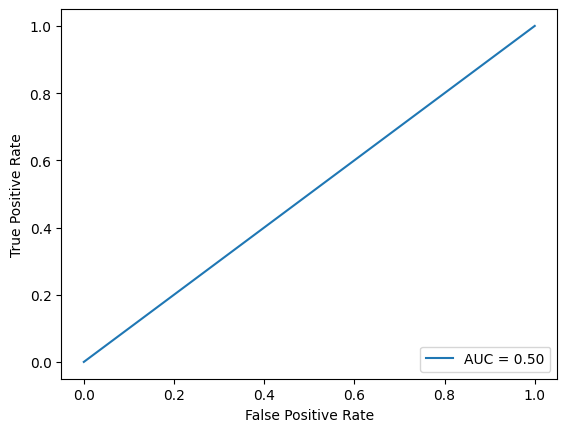

In [74]:
roc(dummy_pred)

This dummy model is a starting point for the modeling process, but based on the poor accuracy, large number of false negatives, and poor ROC curve, we will need to find a better performing model.

<a id='logreg'></a>
## Simple Logistic Regression

Logistic regression, which uses a sigmoid function, is a common model to employ for binary classification.  We will start with the default parameters.  Throughout the modeling process, I will use a consistent random_state for reproducibility, when the algorithm allows.  

Each model will utilize the pipeline and ColumnTransformers we created earlier.  We will fit on our training data (X_train, y_train), then create a prediction based on X_train.  We will also track the time it takes the model to create that prediction.  This process will be repeated for each model as we refine our approach based on the cross-valuation metrics returned, as well as the confusion matrices and ROC curves.

In [75]:
# default logistic regression
logreg1 = Pipeline(steps=[('ct', CT),
                            ('logreg1', LogisticRegression(random_state=24))])
logreg1.fit(X_train, y_train)
begin = time.time()
y_log1_pred = logreg1.predict(X_train)
end = time.time()
logreg1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {logreg1_time} seconds.
""")


The total time to predict for this model is 0.024 seconds.



The chosen metrics for each cross-validation include:
- accuracy: the total number of correctly-predicted values (positive = fall, vs. negative = no fall) divided by the total values
- recall: the total number of true positives divided by the total number of **actual total** positive values
- precision: the total number of true positives divided by the number of **predicted** positive values
- and f1: the "harmonic mean" of recall and precision.  Equal to (2 x  (precision x recall)) / (precision + recall)

The best model should of course have high accuracy in predicting fall vs. no fall, but it is also very important to have high recall to minimize the likelihood of "false negatives".  A false negative in this case would mean NOT predicting a fall when a fall had actually occurred.  This circumstance could be catastrophic to the injured party, due to the delays in notification to family and emergency personnel and therefore an increase in likely complications related to the fall.  

I included precision and F1 score as well to have a more complete picture of each model's predictive ability, though it is less of a concern if a model had a "false positive", and predicted a fall when none had occurred.  The impact in that case could still be serious in terms of wasting emergency personnel time & resources, as well as stress and inconvenience for the user and his/her family, but at least we would not have the above scenario of missing an actual fall event and potentially worsening its impact. 

In [76]:
# evaluating the training set via cross-validation with 5 folds
logreg1_scores = cross_validate(logreg1, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [77]:
# this produces an array of individual values
logreg1_scores

{'fit_time': array([0.24599695, 0.22168231, 0.238904  , 0.25885248, 0.22541237]),
 'score_time': array([0.0239172 , 0.02203774, 0.0179987 , 0.01691842, 0.02254629]),
 'test_accuracy': array([0.91806356, 0.91833177, 0.91927048, 0.92490278, 0.92100322]),
 'train_accuracy': array([0.92188286, 0.92205049, 0.92010594, 0.9203071 , 0.91990747]),
 'test_recall': array([0.88299275, 0.88727752, 0.88757006, 0.89878009, 0.89020772]),
 'train_recall': array([0.89293662, 0.89384324, 0.88849514, 0.88981375, 0.88981375]),
 'test_precision': array([0.91277683, 0.90976681, 0.91161531, 0.91507217, 0.91339648]),
 'train_precision': array([0.91310577, 0.91272513, 0.91279316, 0.9121399 , 0.91121614]),
 'test_f1': array([0.8976378 , 0.89838145, 0.89943201, 0.90685296, 0.90165303]),
 'train_f1': array([0.90290858, 0.90318551, 0.90048027, 0.90083851, 0.90038777])}

In [78]:
# the function we created previously will find the mean of each metric, 
# and save them off as variables
logreg1_results = results(logreg1_scores)

In [79]:
# sanity check to make sure the function works correctly
logreg1_scores['test_accuracy'].mean() == logreg1_results._test_accuracy

True

In [80]:
# and now we can quickly print out a summary
print_results(logreg1_results)


    The mean train accuracy score is 0.9209.
    The mean test accuracy score is 0.9203. 

    The mean train recall score is 0.891.
    The mean test recall score is 0.8894. 

    The mean train precision score is 0.9124.
    The mean test precision score is 0.9125. 

    The mean train f1 score is 0.9016.
    The mean test f1 score is 0.9008. 

    **********************************
    The mean fit time for this model is 0.2382 seconds.
    The mean score time for this model is 0.0207 seconds.
    


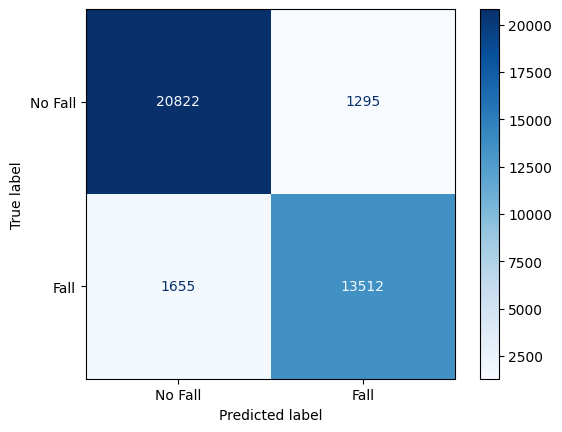

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       0.93      0.94      0.93     22117
        Fall       0.91      0.89      0.90     15167

    accuracy                           0.92     37284
   macro avg       0.92      0.92      0.92     37284
weighted avg       0.92      0.92      0.92     37284



In [81]:
conf_matrix(y_log1_pred)

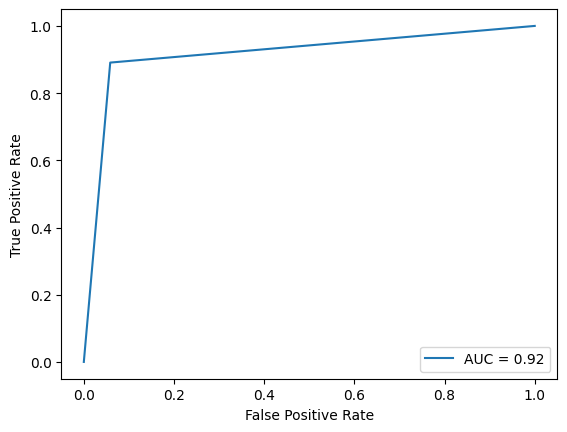

In [82]:
roc(y_log1_pred)

**Summary**: our accuracy has increased from 59% on the dummy model up to 92%, but the recall is low and there are still 1,655 false negatives.  Next we will tune some selected hyperparameters below

## Tuned Logistic Regression

Adding max_iter=1000, and stronger regularization (C=0.01)

A larger max_iter (iterations) allows for convergence and finding a log loss.  However, more iterations are more computationally expensive.  The default is 100.

C is the inverse of regularization strength, so a smaller number means more regularization.  The default is 1.0.

In [83]:
# logistic regression with max_iter, C
logreg2 = Pipeline(steps=[('ct', CT),
                            ('logreg2', LogisticRegression(
                                max_iter = 1000,
                                C=0.01,
                                random_state=24))])
logreg2.fit(X_train, y_train)
begin = time.time()
y_log2_pred = logreg2.predict(X_train)
end = time.time()
logreg2_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {logreg2_time} seconds.
""")


The total time to predict for this model is 0.0169 seconds.



In [84]:
logreg2_scores = cross_validate(logreg2, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [85]:
logreg2_results = results(logreg2_scores)

In [86]:
print_results(logreg2_results)


    The mean train accuracy score is 0.9224.
    The mean test accuracy score is 0.9223. 

    The mean train recall score is 0.8891.
    The mean test recall score is 0.889. 

    The mean train precision score is 0.9176.
    The mean test precision score is 0.9175. 

    The mean train f1 score is 0.9031.
    The mean test f1 score is 0.903. 

    **********************************
    The mean fit time for this model is 0.1224 seconds.
    The mean score time for this model is 0.0156 seconds.
    


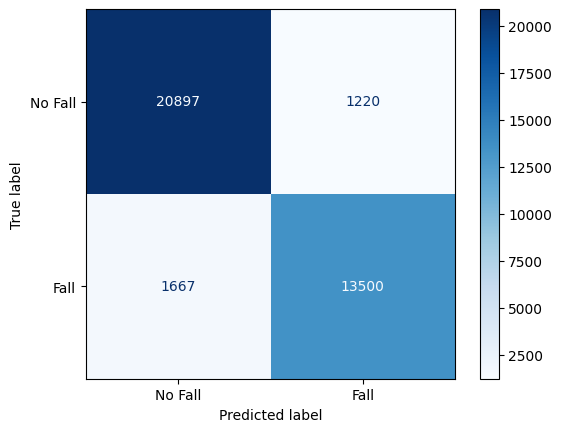

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       0.93      0.94      0.94     22117
        Fall       0.92      0.89      0.90     15167

    accuracy                           0.92     37284
   macro avg       0.92      0.92      0.92     37284
weighted avg       0.92      0.92      0.92     37284



In [87]:
conf_matrix(y_log2_pred)

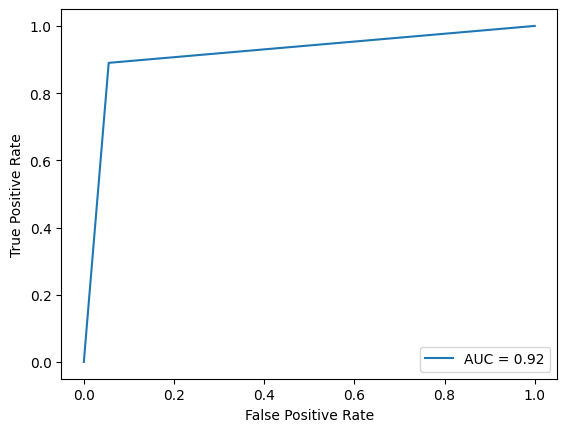

In [88]:
roc(y_log2_pred)

**Summary**: accuracy remains about the same as with the default logistic regression model, and the number of false negatives has actually increased slightly (from 1,655 to 1,667).  Let's trial a different model type and compare that.  Next will be k nearest neighbors

<a id='knn'></a>
## k Nearest Neighbors

with default hyperparameters, including n_neighbors=5

Of note, we are scaling our numeric data through our pipelines and ColumnTransformer, to be able to use this distance-based algorithm.  

In [89]:
# default kNN

knn1 = Pipeline(steps=[('ct', CT),
                            ('knn', KNeighborsClassifier())])
knn1.fit(X_train, y_train)
begin = time.time()
y_knn1_pred = knn1.predict(X_train)
end = time.time()
knn1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {knn1_time} seconds.
""")


The total time to predict for this model is 28.0661 seconds.



In [90]:
knn1_scores = cross_validate(knn1, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [91]:
knn1_results = results(knn1_scores)

In [92]:
print_results(knn1_results)


    The mean train accuracy score is 0.9941.
    The mean test accuracy score is 0.9906. 

    The mean train recall score is 0.99.
    The mean test recall score is 0.9845. 

    The mean train precision score is 0.9955.
    The mean test precision score is 0.9924. 

    The mean train f1 score is 0.9927.
    The mean test f1 score is 0.9884. 

    **********************************
    The mean fit time for this model is 0.0207 seconds.
    The mean score time for this model is 4.0098 seconds.
    


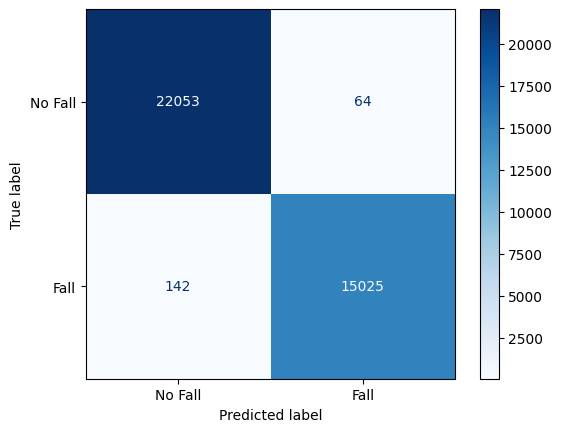

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       0.99      1.00      1.00     22117
        Fall       1.00      0.99      0.99     15167

    accuracy                           0.99     37284
   macro avg       0.99      0.99      0.99     37284
weighted avg       0.99      0.99      0.99     37284



In [93]:
conf_matrix(y_knn1_pred)

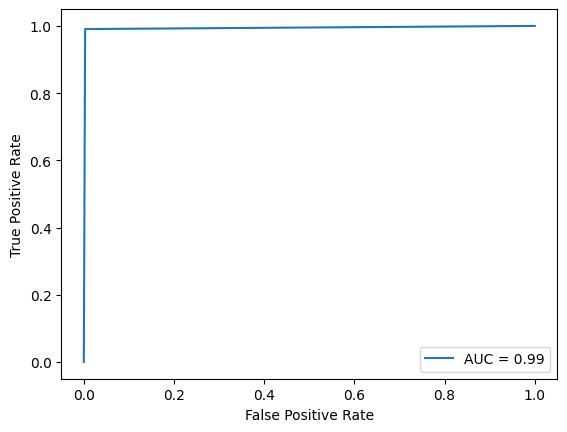

In [94]:
roc(y_knn1_pred)

**Summary**: accuracy much improved, now just above 99%.  And false negatives are down to 142.  Our aim is to be as close to perfect as possible with our classification and avoid all false negatives.  Let's try to tune this algorithm by decreasing the n_neighbors hyperparameter and perhaps creating more accurate classification

### Tuned kNN

defining n_neighbors = 3  (default n_neighbors= 5)

In [95]:
# kNN with n_neighbors=3

knn2 = Pipeline(steps=[('ct', CT),
                            ('knn2', KNeighborsClassifier(n_neighbors=3))])
knn2.fit(X_train, y_train)
begin = time.time()
y_knn2_pred = knn2.predict(X_train)
end = time.time()
knn2_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {knn2_time} seconds.
""")


The total time to predict for this model is 18.5038 seconds.



In [96]:
knn2_scores = cross_validate(knn2, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [97]:
knn2_results = results(knn2_scores)

In [98]:
print_results(knn2_results)


    The mean train accuracy score is 0.9963.
    The mean test accuracy score is 0.9915. 

    The mean train recall score is 0.9938.
    The mean test recall score is 0.9862. 

    The mean train precision score is 0.997.
    The mean test precision score is 0.9928. 

    The mean train f1 score is 0.9954.
    The mean test f1 score is 0.9895. 

    **********************************
    The mean fit time for this model is 0.0171 seconds.
    The mean score time for this model is 2.8515 seconds.
    


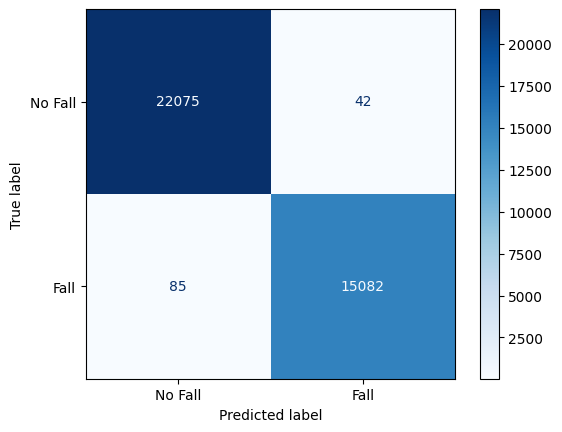

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      0.99      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [99]:
conf_matrix(y_knn2_pred)

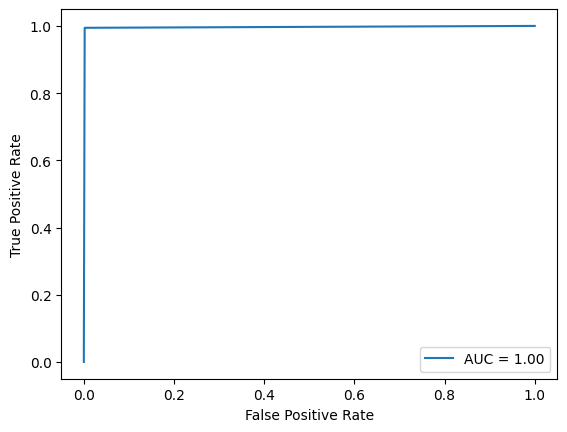

In [100]:
roc(y_knn2_pred)

**Summary**:  accuracy even a little higher (99.15%), and false negatives down from 142 to 85, but the goal is ultimately zero.  Perhaps grid searching through multiple hyperparameters will be a more efficient way to find the best hyperparameters for this algorithm.  

## GridSearchCV for kNN

In [101]:
# knn_gs = Pipeline(steps=[('ct', CT),
#                             ('knn', KNeighborsClassifier())])

We will perform a GridSearch (with cross-validation) that includes the default hyperparameters, but also additional n_neighbors options, an alternate distance metric (default is 'minkowski', or Euclidean distance) and alternate weight calculation (default is 'uniform' weight).  Weighting by 'distance' means the algorithm will weight points by the inverse of their distance.

In [102]:
# commented out the GridSearch (and review of parameters) 
# to save time on re-running

# params = {}
# params['knn__n_neighbors'] = [1, 3, 5, 11]
# params['knn__metric'] = ['minkowski', 'manhattan']
# params['knn__weights'] = ['uniform', 'distance']

# knn_gs1 = GridSearchCV(estimator=knn_gs,
#                  param_grid=params,
#                  cv=5,
#                  verbose=3,
#                  n_jobs=-2)

In [103]:
# knn_gs1.fit(X_train, y_train)

In [104]:
# knn_gs1.best_params_

# results:
# knn__metric: manhattan
# knn__n_neighbors: 1
# knn_weights: uniform

In [105]:
# knn_gs1.best_estimator_

In [106]:
knn_gs1_best = Pipeline(steps=[('ct', CT),
                            ('knn', KNeighborsClassifier(
                                metric='manhattan',
                                n_neighbors=1,
                                weights='uniform'))])

knn_gs1_scores = cross_validate(knn_gs1_best, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [107]:
knn_gs1_results = results(knn_gs1_scores)

In [108]:
print_results(knn_gs1_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9962. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9942. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9964. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9953. 

    **********************************
    The mean fit time for this model is 0.0199 seconds.
    The mean score time for this model is 3.6419 seconds.
    


In [109]:
# kNN with best GridSearch parameters

knn_gs1_best.fit(X_train, y_train)
begin = time.time()
y_knn_gs1_pred = knn_gs1_best.predict(X_train)
end = time.time()
knn_gs1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {knn_gs1_time} seconds.
""")


The total time to predict for this model is 24.6203 seconds.



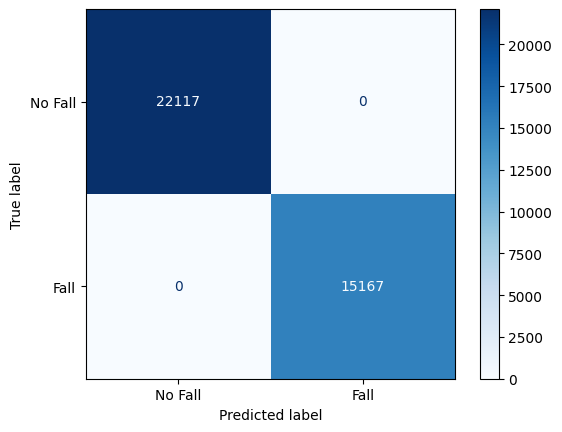

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [110]:
conf_matrix(y_knn_gs1_pred)

# classifying 100% correctly

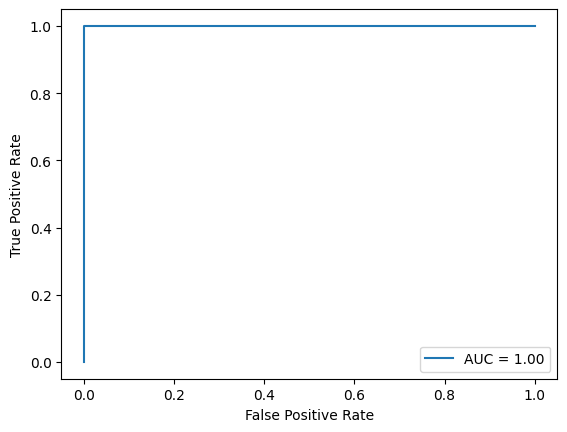

In [111]:
roc(y_knn_gs1_pred)

**Summary**:  accuracy is now 99.6% and recall 99.4%, with ZERO false negatives & false positives.  One concern however is the prediction time.  It varies on re-running, but is currently at >20 seconds. 

We have not trialed any tree-based models, which should have much lower predict times compared to kNN since they are not distance-based.  Let's start with the simplest version and work our way up.

<a id='tree'></a>
## Decision Tree

In [112]:
# default Decision Tree

dt_pipe = Pipeline(steps=[('ct', CT),
                            ('dt', DecisionTreeClassifier(random_state=24))])
dt_pipe.fit(X_train, y_train)
begin = time.time()
y_dt_pred = dt_pipe.predict(X_train)
end = time.time()
dt_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {dt_time} seconds.
""")


The total time to predict for this model is 0.0156 seconds.



This is a MUCH faster predict time compared to kNN models

In [113]:
dt_pipe_scores = cross_validate(dt_pipe, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [114]:
dt_results = results(dt_pipe_scores)

In [115]:
print_results(dt_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9855. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9812. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9831. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9821. 

    **********************************
    The mean fit time for this model is 0.3737 seconds.
    The mean score time for this model is 0.0145 seconds.
    


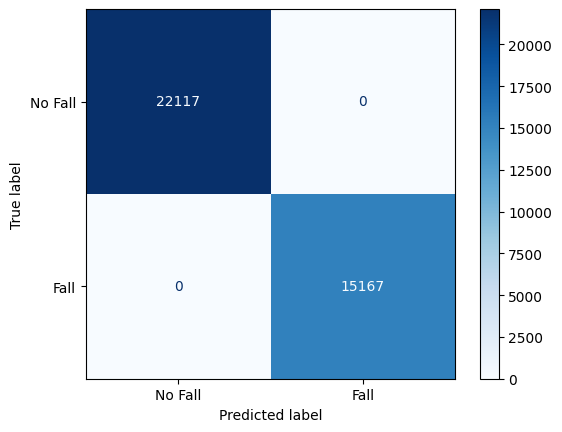

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [116]:
conf_matrix(y_dt_pred)

# classifying 100% correctly

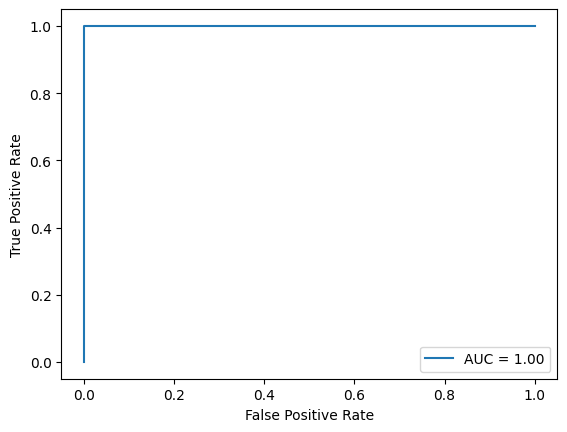

In [117]:
roc(y_dt_pred)

**Summary**:
- pros: MUCH faster (0.02 seconds), and zero false negatives (and false positives) again
- cons: technically accuracy and recall scores are lower than our most recent kNN model, which would be a greater concern with unseen data in the future.  We want to be sure we have the best model while also balancing computational expense
    
Can we use ensemble methods like Random Forest or Gradient Boosting to improve the Decision Tree algorithm?  We'll start with Random Forest first

## Random Forest

In [118]:
# default Random Forest

rfc1 = Pipeline([('ct', CT), ('rfc', RandomForestClassifier(random_state=24))])
rfc1.fit(X_train, y_train)
begin = time.time()
y_rfc1_pred = rfc1.predict(X_train)
end = time.time()
rfc1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {rfc1_time} seconds.
""")


The total time to predict for this model is 0.273 seconds.



In [119]:
rfc1_scores = cross_validate(rfc1, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [120]:
rfc1_results = results(rfc1_scores)

In [121]:
print_results(rfc1_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9941. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9884. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9971. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9927. 

    **********************************
    The mean fit time for this model is 3.48 seconds.
    The mean score time for this model is 0.0792 seconds.
    


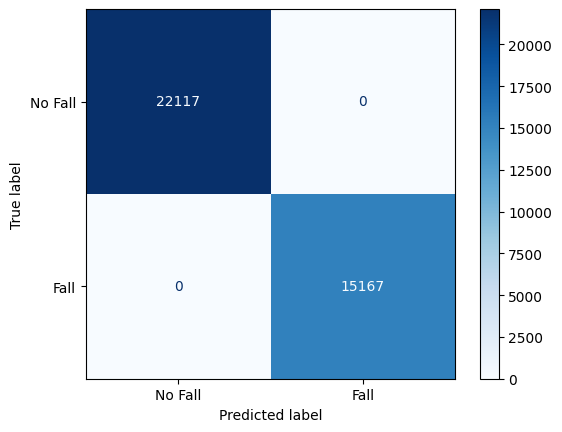

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [122]:
conf_matrix(y_rfc1_pred)
# Also classifying 100% correctly

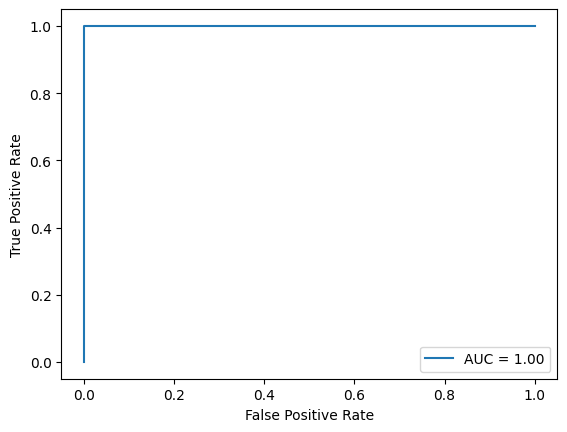

In [123]:
roc(y_rfc1_pred)

**Summary**:  accuracy is improved (>99% again) and recall up slightly as well, still with zero false negatives & false positives.  And the predict time (~0.28 sec), though slower than a single DecisionTree, is still much faster than kNN. 

Can this model be improved?  Let's GridSearch through additional parameters to see.

## GridSearch for RFC

We will GridSearch again, continuing to include the default hyperparameters (which did perform well in the iteration above), but also including values above & below the default hyperparameters for n_estimators and min_samples_leaf.

In [124]:
# using same rfc1 (default) from above

In [125]:
# commented out to save time on re-running

# params = {}
# params['rfc__n_estimators'] = [50, 100, 200]
# params['rfc__min_samples_leaf'] = [1, 3, 5]

# rfc_gs1 = GridSearchCV(estimator=rfc1,
#                  param_grid=params,
#                  cv=5,
#                  verbose=3,
#                  n_jobs=-2)

In [126]:
# rfc_gs1.fit(X_train, y_train)

In [127]:
# rfc_gs1.best_params_

#results:
# rfc__min_samples_leaf: 1
# rfc__n_estimators: 200

In [128]:
# rfc_gs1.best_estimator_

In [129]:
rfc_gs1_best = Pipeline([('ct', CT), 
                                    ('rfc', RandomForestClassifier(
                                    n_estimators=200,
                                    min_samples_leaf=1,
                                    random_state=24))])


rfc_gs1_scores = cross_validate(rfc_gs1_best, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [130]:
rfc_gs1_results = results(rfc_gs1_scores)

In [131]:
print_results(rfc_gs1_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9941. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9887. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9967. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9927. 

    **********************************
    The mean fit time for this model is 7.0818 seconds.
    The mean score time for this model is 0.1566 seconds.
    


In [132]:
# finding predict time for best RFC

rfc_gs1_best.fit(X_train, y_train)
begin = time.time()
y_rfc_gs1_pred = rfc_gs1_best.predict(X_train)
end = time.time()
rfc_gs1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {rfc_gs1_time} seconds.
""")


The total time to predict for this model is 0.5303 seconds.



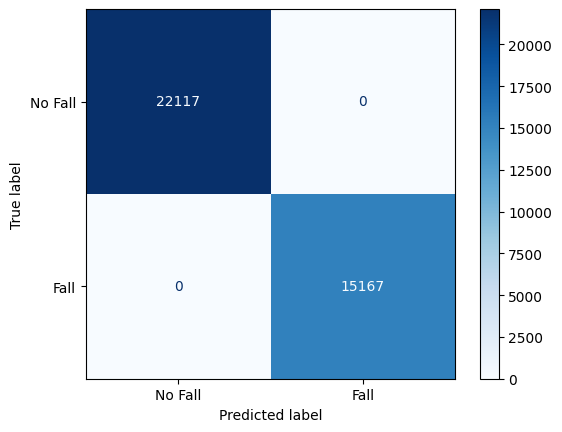

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [133]:
conf_matrix(y_rfc_gs1_pred)

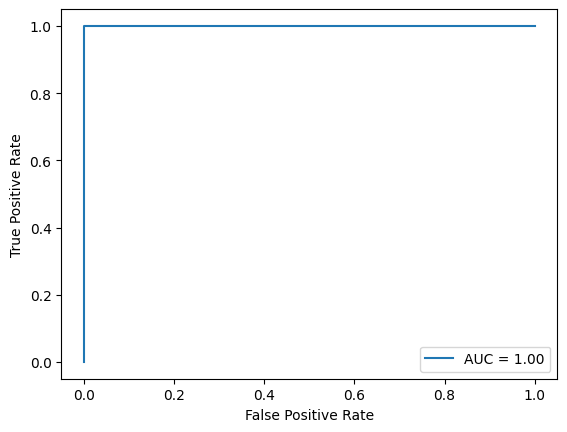

In [134]:
roc(y_rfc_gs1_pred)

**Summary**:  accuracy and recall virtually identical to prior RandomForest, and false negatives & false positives are still zero.  Maybe we've reached the best we can do in terms of accuracy, recall, speed, etc.  But there are still other options to try.  Let's have a more in depth review so far...

### Let's pause to compare the models thus far...

#### Accuracy scores:

In [135]:
# here's a function to collect accuracy scores so far

# creating a list of model names that will be easier to read
models1 = ['Log Reg 1', 'Log Reg 2', 'kNN 1', 'kNN 2', 'kNN GS1', 'DT', 'RFC 1', 'RFC GS1']

# creating a list of the collected results for each model
results1 = [logreg1_results, logreg2_results, knn1_results, knn2_results, knn_gs1_results, dt_results, 
          rfc1_results, rfc_gs1_results]
test_acc_list = []

# function to append to acc_check list
def acc_check():
    for result in results1:
        test_acc_list.append(result._test_accuracy)

In [136]:
# running function
acc_check()

Thanks to __[this](https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/)__ geeksforgeeks.org post for guidance on creating and sorting this dictionary

In [137]:
# creating a dictionary of model names and their test accuracy score means
acc_check_dict = {models1: test_acc_list for models1, test_acc_list in zip(models1, test_acc_list)}
list(acc_check_dict.items())

[('Log Reg 1', 0.9203143624304382),
 ('Log Reg 2', 0.9222991359329973),
 ('kNN 1', 0.9906125520221517),
 ('kNN 2', 0.991497673211966),
 ('kNN GS1', 0.9961914043952135),
 ('DT', 0.9854897190242656),
 ('RFC 1', 0.9940992915893757),
 ('RFC GS1', 0.9940993023808605)]

In [138]:
acc_check_keys = list(acc_check_dict.keys())
acc_check_values = list(acc_check_dict.values())
acc_check_index = np.argsort(acc_check_values)[:][::-1]
sorted_acc_check_dict = {acc_check_keys[i]: acc_check_values[i] for i in acc_check_index}
 
print(sorted_acc_check_dict)

{'kNN GS1': 0.9961914043952135, 'RFC GS1': 0.9940993023808605, 'RFC 1': 0.9940992915893757, 'kNN 2': 0.991497673211966, 'kNN 1': 0.9906125520221517, 'DT': 0.9854897190242656, 'Log Reg 2': 0.9222991359329973, 'Log Reg 1': 0.9203143624304382}


kNN GS1 scores highest for cross-validated test accuracy, though the Random Forest models (RFC GS1 and RFC 1) are close.

#### Recall scores:

In [139]:
test_rec_list = []


def recall_check():
    for result in results1:
        test_rec_list.append(result._test_recall)

In [140]:
recall_check()

In [141]:
rec_check_dict = {models1: test_rec_list for models1, test_rec_list in zip(models1, test_rec_list)}
list(rec_check_dict.items())

[('Log Reg 1', 0.8893656267543507),
 ('Log Reg 2', 0.8889701962221321),
 ('kNN 1', 0.9845054216842595),
 ('kNN 2', 0.9862197871317072),
 ('kNN GS1', 0.9941979252176834),
 ('DT', 0.9812090950326458),
 ('RFC 1', 0.98839574176478),
 ('RFC GS1', 0.988725426591823)]

In [142]:
rec_check_keys = list(rec_check_dict.keys())
rec_check_values = list(rec_check_dict.values())
rec_check_index = np.argsort(rec_check_values)[:][::-1]
sorted_rec_check_dict = {rec_check_keys[i]: rec_check_values[i] for i in rec_check_index}
 
print(sorted_rec_check_dict)

{'kNN GS1': 0.9941979252176834, 'RFC GS1': 0.988725426591823, 'RFC 1': 0.98839574176478, 'kNN 2': 0.9862197871317072, 'kNN 1': 0.9845054216842595, 'DT': 0.9812090950326458, 'Log Reg 1': 0.8893656267543507, 'Log Reg 2': 0.8889701962221321}


**Summary:** So far the knn from the GridSearch (manhattan, n_neighbors = 1, weights = uniform) appears to be the best performer in terms of accuracy and recall.  But is the greater computational expense worth it?  There may still be a better balance we can find.  We have some more ensemble methods to consider.

<a id='sc'></a>
## Stacking Classifier

I'm going to try the default versions of 3 of our most basic classifiers so far (logistic regression, k Nearest Neighbors, and Decision Tree).  No need to tweak hyperparameters yet unless the default versions seem very promising.  

In [143]:
# Stacking Classifier with default settings for LogReg, kNN, DT

estimators = [
    ('logreg_est', LogisticRegression(random_state=24)),
    ('knn_est', KNeighborsClassifier()),
    ('dt_est', DecisionTreeClassifier(random_state=24))
]

sc = Pipeline(steps=[('ct', CT),
                            ('sc', StackingClassifier(estimators))])

sc.fit(X_train, y_train)
begin = time.time()
y_sc_pred = sc.predict(X_train)
end = time.time()
sc_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {sc_time} seconds.
""")


The total time to predict for this model is 24.8129 seconds.



In [144]:
sc_scores = cross_validate(sc, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [145]:
sc_results = results(sc_scores)

In [146]:
print_results(sc_results)


    The mean train accuracy score is 0.9982.
    The mean test accuracy score is 0.993. 

    The mean train recall score is 0.9974.
    The mean test recall score is 0.9887. 

    The mean train precision score is 0.9981.
    The mean test precision score is 0.9941. 

    The mean train f1 score is 0.9977.
    The mean test f1 score is 0.9914. 

    **********************************
    The mean fit time for this model is 14.7769 seconds.
    The mean score time for this model is 3.9648 seconds.
    


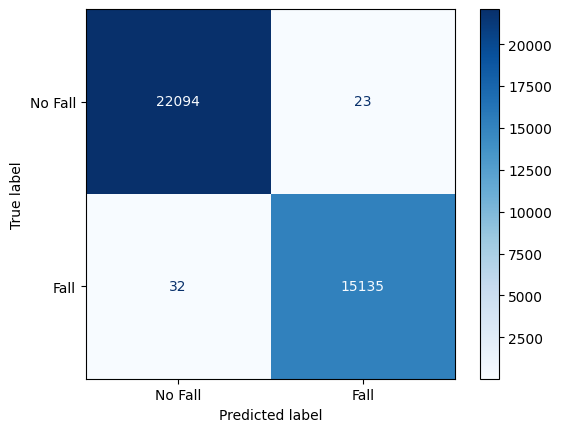

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [147]:
conf_matrix(y_sc_pred)

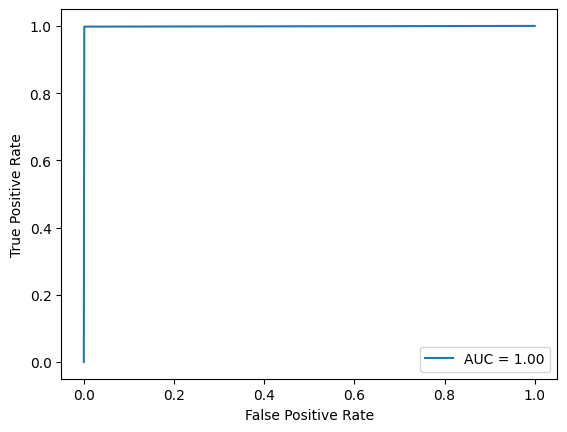

In [148]:
roc(y_sc_pred)

**Summary:**  
- pros: high accuracy and recall
- cons: very slow again (probably due to the inclusion of kNN) and we're now at 32 false negatives!

Let's try a different ensemble method next

## Gradient Boosting

Gradient Boosting is built from the starting point of a Decision Tree, and then improves its predictions by using information about the derivative of the previous model's loss function.  There are many hyperparameters to tune, but again we will start with the default hyperparameters to assess general performance.

In [149]:
# default Gradient Boosting

gbc = Pipeline(steps=[('ct', CT),
                            ('gbc', GradientBoostingClassifier(random_state=24))])

gbc.fit(X_train, y_train)
begin = time.time()
y_gbc_pred = gbc.predict(X_train)
end = time.time()
gbc_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {gbc_time} seconds.
""")


The total time to predict for this model is 0.0522 seconds.



In [150]:
gbc_scores = cross_validate(gbc, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [151]:
gbc_results = results(gbc_scores)

In [152]:
print_results(gbc_results)


    The mean train accuracy score is 0.9879.
    The mean test accuracy score is 0.9854. 

    The mean train recall score is 0.978.
    The mean test recall score is 0.9748. 

    The mean train precision score is 0.9922.
    The mean test precision score is 0.989. 

    The mean train f1 score is 0.9851.
    The mean test f1 score is 0.9819. 

    **********************************
    The mean fit time for this model is 6.6682 seconds.
    The mean score time for this model is 0.017 seconds.
    


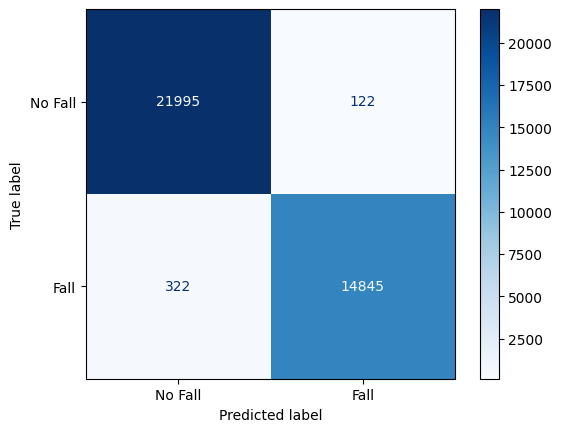

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       0.99      0.99      0.99     22117
        Fall       0.99      0.98      0.99     15167

    accuracy                           0.99     37284
   macro avg       0.99      0.99      0.99     37284
weighted avg       0.99      0.99      0.99     37284



In [153]:
conf_matrix(y_gbc_pred)

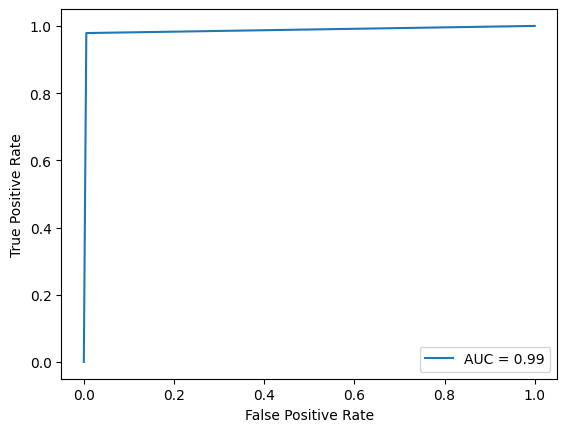

In [154]:
roc(y_gbc_pred)

**Summary:** Accuracy and recall are down, and false negatives are now at 322!  We could spend time GridSearching through many hyperparameters to fine tune this model, or simply guess & test, but there is another option to consider that is known to perform well with classification problems.  Let's try the XG Boost classifier algorithm first, and if it's not an improvement, we can return to Gradient Boosting

<a id='xgboost'></a>
## eXtreme Gradient Boosting (XG Boost)

In [155]:
# default XG Boost (which DOES have n_jobs=12 as default, so naturally its fast)

XG_boost1 = Pipeline(steps=[('ct', CT),
                            ('xgb1', xgboost.XGBClassifier(random_state=24))])

XG_boost1.fit(X_train, y_train)
begin = time.time()
y_XGB_pred = XG_boost1.predict(X_train)
end = time.time()
XG_boost1_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {XG_boost1_time} seconds.
""")

[09:20:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The total time to predict for this model is 0.1077 seconds.



In [156]:
XG_boost1_scores = cross_validate(XG_boost1, X_train, y_train, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

[09:20:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [157]:
XG_boost1_results = results(XG_boost1_scores)

In [158]:
print_results(XG_boost1_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9971. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9944. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9985. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9964. 

    **********************************
    The mean fit time for this model is 4.4091 seconds.
    The mean score time for this model is 0.0355 seconds.
    


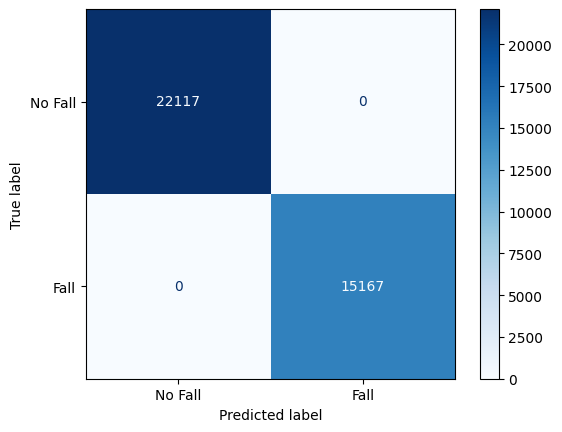

*************************************************************************************
              precision    recall  f1-score   support

     No Fall       1.00      1.00      1.00     22117
        Fall       1.00      1.00      1.00     15167

    accuracy                           1.00     37284
   macro avg       1.00      1.00      1.00     37284
weighted avg       1.00      1.00      1.00     37284



In [159]:
conf_matrix(y_XGB_pred)

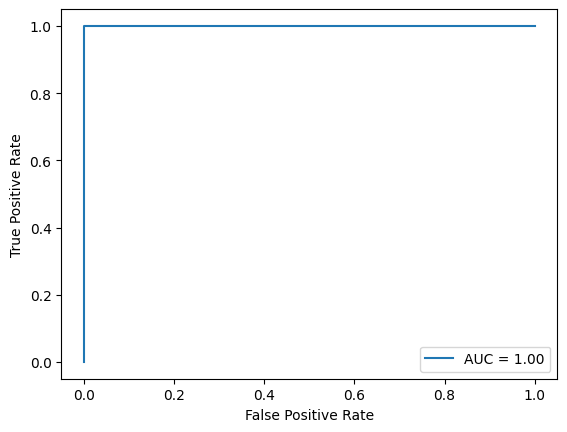

In [160]:
roc(y_XGB_pred)

**Summary:** Wow, this is the highest accuracy and recall, with very minimal overfitting, and with zero false negatives & false positives, and a VERY fast predict time (though default IS n_jobs=12).  Again, we could perform a GridSearch for this model, though there are MANY hyperparameters to consider.  Instead, let's do another recap of all the models so far, with visuals for comparison.

<a id='final'></a>
# Evaluation

To review, my chosen metrics for evaluation are accuracy, recall (aiming to reduce false negatives, therefore catching almost all or all of the falls that occurred in the data), precision and f1 score, as well as viewing the confusion matrix and ROC for each model. Let's look at some bar graphs of the first four metrics, and the score/predict time, for each model below.

<a id='visuals'></a>
## Visuals for df_raw Models using Cross-Validation Metrics

### Not using unseen X_test data or the separate ARCO test dataset yet

To create visualizations for each test metric, I can create a function that will be able to create a list of all values from the results for each model above

In [161]:
# creating a separate list of models so visuals have neater titles
models = ['LR1', 'LR2', 'kNN1', 'kNN2', 'kNNGS', 'DT', 'RFC', 'RFCGS', 'SC', 'GBC', 'XGB']

In [162]:
# a list of all the model's results
results_all = [logreg1_results, logreg2_results, knn1_results, knn2_results, knn_gs1_results, dt_results, 
          rfc1_results, rfc_gs1_results, sc_results, gbc_results, XG_boost1_results]

# blank lists to append all values too
train_accuracy_list = []
test_accuracy_list = []
train_recall_list = []
test_recall_list = []
train_precision_list = []
test_precision_list = []
train_f1_list = []
test_f1_list = []
fit_time_list = []
score_time_list = []

def metric():
    """
    creating a function to append all model's results to the 
    above blank lists
    
    """
    for result in results_all:
        train_accuracy_list.append(result._train_accuracy)
        test_accuracy_list.append(result._test_accuracy)
        train_recall_list.append(result._train_recall)
        test_recall_list.append(result._test_recall)
        train_precision_list.append(result._train_precision)
        test_precision_list.append(result._test_precision)
        train_f1_list.append(result._train_f1)
        test_f1_list.append(result._test_f1)
        fit_time_list.append(result._fit_time)
        score_time_list.append(result._score_time)

In [163]:
# running the function prior to creating dictionaries below
metric()

### Cross-Val Test Accuracy

In [164]:
test_acc_dict = {models: test_accuracy_list for models, test_accuracy_list in zip(models, test_accuracy_list)}
list(test_acc_dict.items())

[('LR1', 0.9203143624304382),
 ('LR2', 0.9222991359329973),
 ('kNN1', 0.9906125520221517),
 ('kNN2', 0.991497673211966),
 ('kNNGS', 0.9961914043952135),
 ('DT', 0.9854897190242656),
 ('RFC', 0.9940992915893757),
 ('RFCGS', 0.9940993023808605),
 ('SC', 0.992999657262439),
 ('GBC', 0.9853556024497534),
 ('XGB', 0.9971032740789683)]

In [165]:
acc_keys = list(test_acc_dict.keys())
acc_values = list(test_acc_dict.values())
acc_index = np.argsort(acc_values)[:][::-1]
sorted_acc_dict = {acc_keys[i]: acc_values[i] for i in acc_index}
 
print(sorted_acc_dict)

{'XGB': 0.9971032740789683, 'kNNGS': 0.9961914043952135, 'RFCGS': 0.9940993023808605, 'RFC': 0.9940992915893757, 'SC': 0.992999657262439, 'kNN2': 0.991497673211966, 'kNN1': 0.9906125520221517, 'DT': 0.9854897190242656, 'GBC': 0.9853556024497534, 'LR2': 0.9222991359329973, 'LR1': 0.9203143624304382}


In [166]:
def invertList(input_list): 
    """
    a function to reverse a list, so larger values can be to the 
    right of the bar graph (or top of horizontal bar graph)
    
    """
    input_list.reverse()
    return input_list

In [167]:
X_acc = list(sorted_acc_dict.keys())
y_acc = [number*100 for number in (list(sorted_acc_dict.values()))]

In [168]:
X_acc_rev = invertList(X_acc)
y_acc_rev = invertList(y_acc)

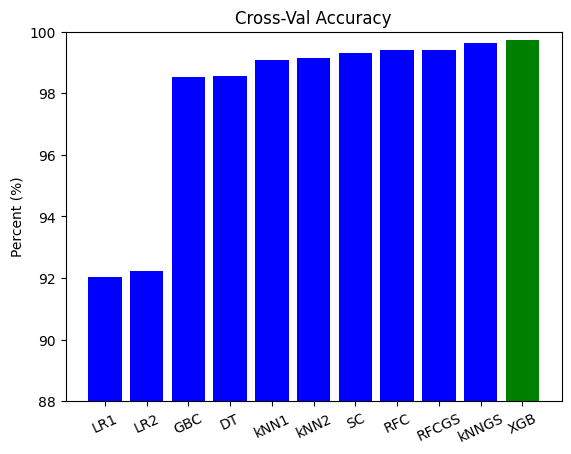

In [169]:
#  Comparing each model by test accuracy scores

fig, ax = plt.subplots()
plt.bar(X_acc_rev, y_acc_rev, color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(88, 100)
plt.grid(False)
ax.set_title("Cross-Val Accuracy")
plt.ylabel("Percent (%)")
plt.savefig('images/cross_val_acc_bar.png', dpi=300, bbox_inches='tight')
plt.show;

XG Boost has the highest accuracy scores on training data (mean of cross-val with 5 folds).  

### Cross-Val Test Recall

In [170]:
test_recall_dict = {models: test_recall_list for models, test_recall_list in zip(models, test_recall_list)}
list(test_recall_dict.items())

[('LR1', 0.8893656267543507),
 ('LR2', 0.8889701962221321),
 ('kNN1', 0.9845054216842595),
 ('kNN2', 0.9862197871317072),
 ('kNNGS', 0.9941979252176834),
 ('DT', 0.9812090950326458),
 ('RFC', 0.98839574176478),
 ('RFCGS', 0.988725426591823),
 ('SC', 0.9886594200772386),
 ('GBC', 0.974813744047297),
 ('XGB', 0.9943956187496754)]

In [171]:
recall_keys = list(test_recall_dict.keys())
recall_values = list(test_recall_dict.values())
recall_index = np.argsort(recall_values)[:][::-1]
sorted_recall_dict = {recall_keys[i]: recall_values[i] for i in recall_index}
 
print(sorted_recall_dict)

{'XGB': 0.9943956187496754, 'kNNGS': 0.9941979252176834, 'RFCGS': 0.988725426591823, 'SC': 0.9886594200772386, 'RFC': 0.98839574176478, 'kNN2': 0.9862197871317072, 'kNN1': 0.9845054216842595, 'DT': 0.9812090950326458, 'GBC': 0.974813744047297, 'LR1': 0.8893656267543507, 'LR2': 0.8889701962221321}


In [172]:
X_recall = list(sorted_recall_dict.keys())
y_recall = [number*100 for number in (list(sorted_recall_dict.values()))]

In [173]:
X_recall_rev = invertList(X_recall)
y_recall_rev = invertList(y_recall)

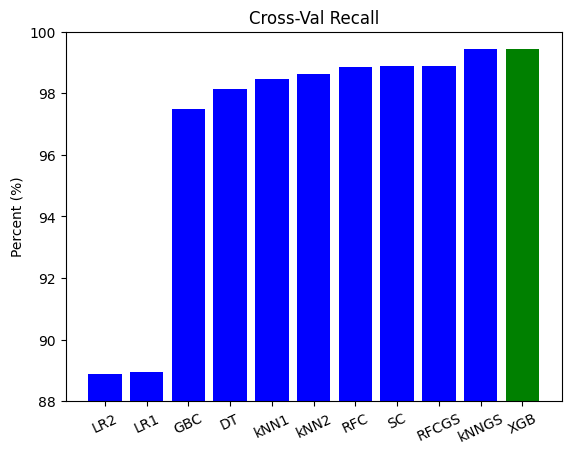

In [174]:
#  Comparing each model by test recall scores

fig, ax = plt.subplots()
plt.bar(X_recall_rev, y_recall_rev, color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(88, 100)
plt.grid(False)
ax.set_title("Cross-Val Recall")
plt.ylabel("Percent (%)")
plt.savefig('images/cross_val_recall_bar.png', dpi=300, bbox_inches='tight')
plt.show;

XG Boost also has the highest recall scores

### Cross-Val Test Precision

In [175]:
test_prec_dict = {models: test_precision_list for models, test_precision_list in zip(models, test_precision_list)}
list(test_prec_dict.items())

[('LR1', 0.9125255209056377),
 ('LR2', 0.9174622031993594),
 ('kNN1', 0.9923608350223414),
 ('kNN2', 0.9928337879117046),
 ('kNNGS', 0.9964326883889575),
 ('DT', 0.983090246903045),
 ('RFC', 0.997073828389712),
 ('RFCGS', 0.9967432022262918),
 ('SC', 0.9941007868988896),
 ('GBC', 0.9890335126940852),
 ('XGB', 0.998477166809004)]

In [176]:
prec_keys = list(test_prec_dict.keys())
prec_values = list(test_prec_dict.values())
prec_index = np.argsort(prec_values)[:][::-1]
sorted_prec_dict = {prec_keys[i]: prec_values[i] for i in prec_index}
 
print(sorted_prec_dict)

{'XGB': 0.998477166809004, 'RFC': 0.997073828389712, 'RFCGS': 0.9967432022262918, 'kNNGS': 0.9964326883889575, 'SC': 0.9941007868988896, 'kNN2': 0.9928337879117046, 'kNN1': 0.9923608350223414, 'GBC': 0.9890335126940852, 'DT': 0.983090246903045, 'LR2': 0.9174622031993594, 'LR1': 0.9125255209056377}


In [177]:
X_prec = list(sorted_prec_dict.keys())
y_prec = [number*100 for number in (list(sorted_prec_dict.values()))]

In [178]:
X_prec_rev = invertList(X_prec)
y_prec_rev = invertList(y_prec)

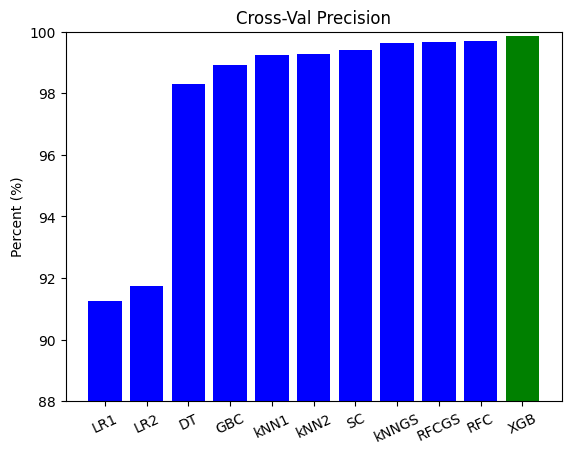

In [179]:
#  Comparing each model by test precision scores

fig, ax = plt.subplots()
plt.bar(X_prec_rev, y_prec_rev, color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(88, 100)
plt.grid(False)
ax.set_title("Cross-Val Precision")
plt.ylabel("Percent (%)")
plt.savefig('images/cross_val_prec_bar.png', dpi=300, bbox_inches='tight')
plt.show;

XG Boost with the highest precision scores as well

### Cross-Val Test F1 Score

In [180]:
test_f1_dict = {models: test_f1_list for models, test_f1_list in zip(models, test_f1_list)}
list(test_f1_dict.items())

[('LR1', 0.9007914479229371),
 ('LR2', 0.9029845728139989),
 ('kNN1', 0.9884140459364813),
 ('kNN2', 0.9895140846702614),
 ('kNNGS', 0.995313418933564),
 ('DT', 0.9821477702097064),
 ('RFC', 0.9927142076252146),
 ('RFCGS', 0.992717329333184),
 ('SC', 0.9913720197068816),
 ('GBC', 0.9818706012636561),
 ('XGB', 0.9964316274390296)]

In [181]:
f1_keys = list(test_f1_dict.keys())
f1_values = list(test_f1_dict.values())
f1_index = np.argsort(f1_values)[:][::-1]
sorted_f1_dict = {f1_keys[i]: f1_values[i] for i in f1_index}
 
print(sorted_f1_dict)

{'XGB': 0.9964316274390296, 'kNNGS': 0.995313418933564, 'RFCGS': 0.992717329333184, 'RFC': 0.9927142076252146, 'SC': 0.9913720197068816, 'kNN2': 0.9895140846702614, 'kNN1': 0.9884140459364813, 'DT': 0.9821477702097064, 'GBC': 0.9818706012636561, 'LR2': 0.9029845728139989, 'LR1': 0.9007914479229371}


In [182]:
X_f1 = list(sorted_f1_dict.keys())
y_f1 = [number*100 for number in (list(sorted_f1_dict.values()))]

In [183]:
X_f1_rev = invertList(X_f1)
y_f1_rev = invertList(y_f1)

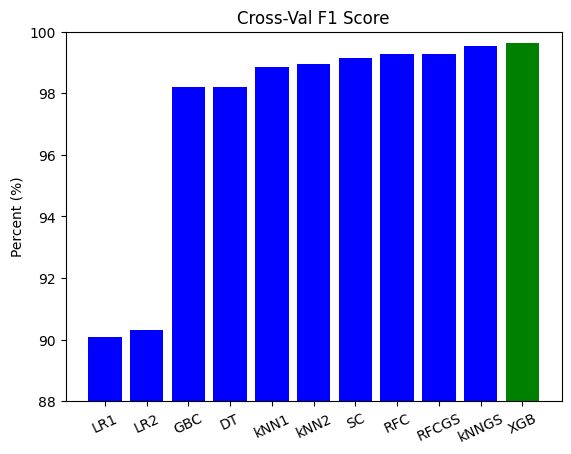

In [184]:
#  Comparing each model by test F1 scores

fig, ax = plt.subplots()
plt.bar(X_f1_rev, y_f1_rev, color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(88, 100)
plt.grid(False)
ax.set_title("Cross-Val F1 Score")
plt.ylabel("Percent (%)")
plt.savefig('images/cross_val_f1_bar.png', dpi=300, bbox_inches='tight')
plt.show;

And XG Boost wins for F1 as well (which makes sense if it has the highest recall and precision)

### Time to Predict

To compare prediction times, rather than using the single predict times from each model above, we will use the mean score time from the cross validation results collected.

In [185]:
model_score_time_dict = {models: score_time_list for models, score_time_list in zip(models, score_time_list)}
list(model_score_time_dict.items())

[('LR1', 0.020683670043945314),
 ('LR2', 0.01558218002319336),
 ('kNN1', 4.0097909450531),
 ('kNN2', 2.8515369415283205),
 ('kNNGS', 3.641857051849365),
 ('DT', 0.014539194107055665),
 ('RFC', 0.07923445701599122),
 ('RFCGS', 0.15658187866210938),
 ('SC', 3.964845609664917),
 ('GBC', 0.01696887016296387),
 ('XGB', 0.03554477691650391)]

In [186]:
time_keys = list(model_score_time_dict.keys())
time_values = list(model_score_time_dict.values())
time_index = np.argsort(time_values)
sorted_time_dict = {time_keys[i]: time_values[i] for i in time_index}
 
print(sorted_time_dict)

{'DT': 0.014539194107055665, 'LR2': 0.01558218002319336, 'GBC': 0.01696887016296387, 'LR1': 0.020683670043945314, 'XGB': 0.03554477691650391, 'RFC': 0.07923445701599122, 'RFCGS': 0.15658187866210938, 'kNN2': 2.8515369415283205, 'kNNGS': 3.641857051849365, 'SC': 3.964845609664917, 'kNN1': 4.0097909450531}


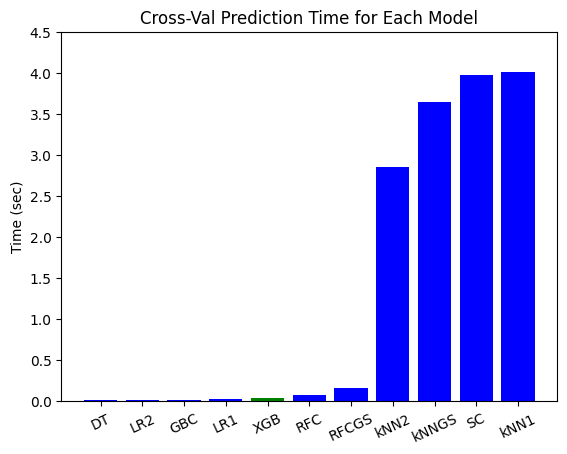

In [280]:
#  Comparing each model by scoring times

X_time = sorted_time_dict.keys()
y_time = sorted_time_dict.values()

fig, ax = plt.subplots()
plt.bar(X_time, y_time, color=['blue', 'blue', 'blue', 'blue', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=25)
plt.ylim(0.0, 4.5)
plt.grid(False)
ax.set_title("Cross-Val Prediction Time for Each Model")
plt.ylabel("Time (sec)")
plt.savefig('images/x_train_time_bar.png', dpi=300, bbox_inches='tight')
plt.show;

XG Boost may not be the fastest time, but it performs much better than the faster models (Decicision Tree, Logistic Regression 1 & 2, and Gradient Boosting) in all other metrics.  And XG Boost is MUCH faster than the kNN models in terms of score time.

### XG Boost compared to original dummy model

In [188]:
y_acc_plot = [(XG_boost1_results._test_accuracy*100), (dummy_cv.mean()*100)]
y_acc_plot

[99.71032740789683, 59.32035192039511]

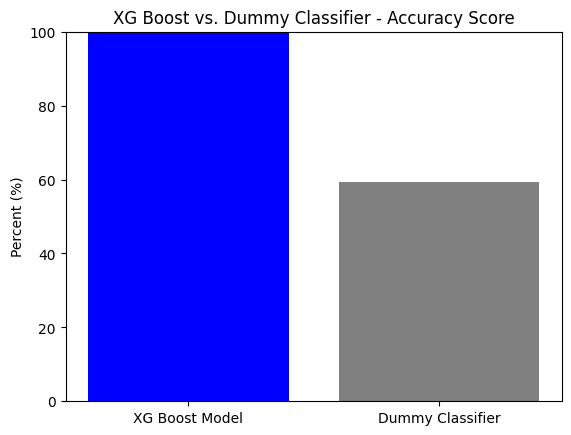

In [189]:
x_acc_plot = ['XG Boost Model', 'Dummy Classifier']
plt.bar(x = x_acc_plot, height = y_acc_plot, color=['blue', 'grey'])
plt.xticks(rotation=0, ha="center", rotation_mode='anchor')
plt.ylabel('Percent (%)')
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("XG Boost vs. Dummy Classifier - Accuracy Score")
plt.savefig('images/xgb_vs_dummy.png', bbox_inches='tight', dpi=300)
plt.show;

<a id='xgbtest'></a>
## Evaluation on the unseen X_test data

We will select the default XG Boost as the best model in terms of achieving the highest performance on the metrics chosen.

In [190]:
# default XG Boost still

XG_boost_test = Pipeline(steps=[('ct', CT),
                            ('xgb_test', xgboost.XGBClassifier(random_state=24))])

XG_boost_test.fit(X_test, y_test)
begin = time.time()
y_XGB_test_pred = XG_boost_test.predict(X_test)
end = time.time()
XG_boost_test_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {XG_boost_test_time} seconds.
""")

[09:21:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The total time to predict for this model is 0.0453 seconds.



In [191]:
XG_boost_test_scores = cross_validate(XG_boost_test, X_test, y_test, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

[09:21:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [192]:
XG_boost_test_results = results(XG_boost_test_scores)

In [193]:
print_results(XG_boost_test_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9905. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9843. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9928. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9885. 

    **********************************
    The mean fit time for this model is 1.6052 seconds.
    The mean score time for this model is 0.0144 seconds.
    


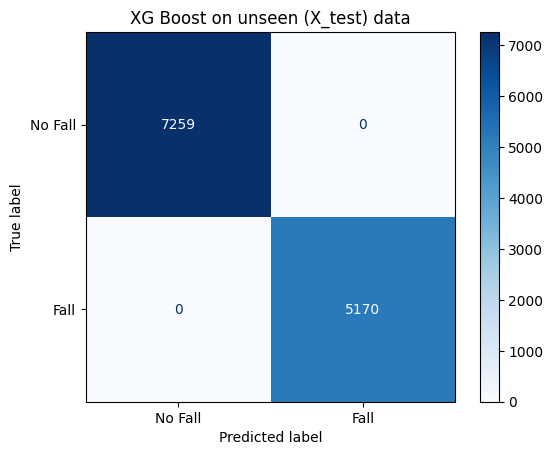

In [194]:
cm_xgb_xt = confusion_matrix(y_test, y_XGB_test_pred, labels=[0,1])
disp_xgb_xt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_xt,display_labels=['No Fall', 'Fall'])
disp_xgb_cm = disp_xgb_xt.plot(cmap=plt.cm.Blues,values_format='g')
plt.title("XG Boost on unseen (X_test) data")
plt.savefig('images/xgb_xtest_conf_matrix.png', bbox_inches='tight', dpi=300)
plt.show();

In [195]:
# checking the above predictions from X_test to the actual y_test counts

y_test.value_counts()

0    7259
1    5170
Name: Fall, dtype: int64

In [196]:
print(classification_report(y_test, y_XGB_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7259
           1       1.00      1.00      1.00      5170

    accuracy                           1.00     12429
   macro avg       1.00      1.00      1.00     12429
weighted avg       1.00      1.00      1.00     12429



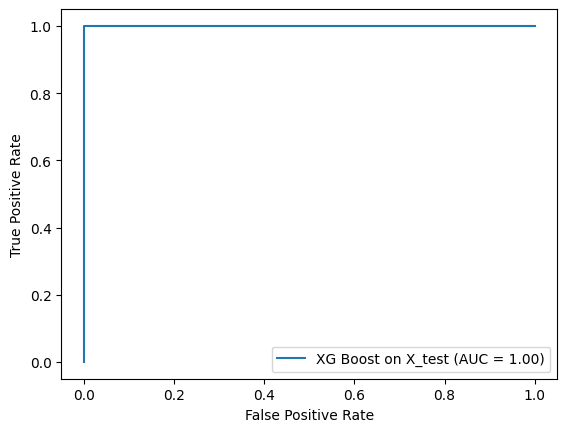

In [197]:
fpr, tpr, thresholds = roc_curve(y_test, y_XGB_test_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='XG Boost on X_test')
display.plot()
plt.show()

**Summary:** The XG Boost model predicts all falls from X_test data correctly and therefore has both zero false negatives and zero false positives.  The XG Boost model is also able to complete this 100% correct binary classification in ~0.02 seconds, which is consistent with its performance on the X_train data.

We'll pause here, before getting to the separate ARCO test dataset evaluation, to consider an alternative model using aggregated features.  If you want to skip this, click __[here.](#arcotest)__

<a id='feat'></a>
# Exploring an Alternative Model

## using df_feat

What if it is too computationally expensive for second-to-second real-time modeling to monitor someone?  Could the system receive a snapshot of intermittent updates (every 5 sec, or even 10 sec) to monitor someone's positionining and make aggregate calculations from that?  We could simulate that circumstance by using the df_feat dataset, which contains aggregate calculations.

In [198]:
df_feat.head()

,Index,Acceleration Mean,Rotation Mean,Acceleration Variance,Rotation Variance,Acc Y Mean,Acc Z Mean,Rot Y Mean,Rot Z Mean,Max Acceleration,...,Yaw,Timestamp,Fall,Acc Y Stdev,Acc Z Stdev,Rot Y Stdev,Rot Z Stdev,Fourier Acc Coef,Fourier Rot Coef,File
0,1,1.300608,41.745840,1.274991,148.636248,-0.125055,0.453730,3.412917,1.036585,9.392141,...,358.229492,1612546353614,0,0.483726,1.312748,109.027999,19.364234,92.343149,2963.954659,Subject1
1,2,1.239625,52.031510,1.069585,195.726419,-0.089449,0.413064,6.641859,1.184541,7.485130,...,359.792999,1612546357756,0,0.391341,1.206264,175.210145,6.265235,84.294529,3538.142670,Subject1
2,3,1.529465,89.170260,1.733220,262.935521,-0.087678,0.515523,7.205940,4.921322,11.018893,...,0.008551,1612546361670,0,1.210065,1.427617,154.932945,40.829397,94.826840,5528.556094,Subject1
3,4,1.060228,10.202447,0.237082,39.333528,-0.130035,0.457962,-6.646342,0.395517,2.969044,...,358.421753,1612546366033,0,0.064298,0.280493,35.358783,3.789023,78.456869,754.981105,Subject1
4,5,1.222219,30.061889,1.283746,120.337842,-0.140402,0.477546,-13.010453,0.682056,11.576874,...,357.713165,1612546370850,0,0.250743,1.194289,95.576180,6.248497,85.555305,2104.332225,Subject1


In [199]:
df_feat.shape

(765, 26)

In [200]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index                  765 non-null    int64  
 1   Acceleration Mean      765 non-null    float64
 2   Rotation Mean          765 non-null    float64
 3   Acceleration Variance  765 non-null    float64
 4   Rotation Variance      765 non-null    float64
 5   Acc Y Mean             765 non-null    float64
 6   Acc Z Mean             765 non-null    float64
 7   Rot Y Mean             765 non-null    float64
 8   Rot Z Mean             765 non-null    float64
 9   Max Acceleration       765 non-null    float64
 10  Max Rotation           765 non-null    float64
 11  First Acceleration     765 non-null    float64
 12  Last Acceleration      765 non-null    float64
 13  Fall Time              765 non-null    int64  
 14  Pitch                  765 non-null    float64
 15  Roll  

In [201]:
# we will copy df_feat
df2 = df_feat.copy()

In [202]:
df2.corr()['Fall']

Index                    0.852075
Acceleration Mean        0.393049
Rotation Mean            0.644353
Acceleration Variance    0.131509
Rotation Variance        0.141548
Acc Y Mean               0.030461
Acc Z Mean              -0.204462
Rot Y Mean               0.074274
Rot Z Mean              -0.009494
Max Acceleration         0.061260
Max Rotation            -0.029804
First Acceleration      -0.028811
Last Acceleration       -0.197886
Fall Time                0.199351
Pitch                   -0.157198
Roll                    -0.848256
Yaw                     -0.189486
Timestamp                0.046914
Fall                     1.000000
Acc Y Stdev              0.579235
Acc Z Stdev              0.175794
Rot Y Stdev              0.144437
Rot Z Stdev              0.698321
Fourier Acc Coef        -0.000304
Fourier Rot Coef         0.543585
Name: Fall, dtype: float64

We will drop 'Index' because it's like 'Feature Line' from df_raw in that it identifies the task being performed, and would therefore be a separate variable that can distinguish whether or not a fall is occurring.

In [203]:
# dropping 'Index'
df2.drop(['Index'], axis=1, inplace=True)

In [204]:
# dropping 'Timestamp' as well
df2.drop(['Timestamp'], axis=1, inplace=True)

In [205]:
# sanity check
df2.shape

(765, 24)

In [206]:
# train-test split
X2 = df2.drop(['Fall'], axis=1)
y2 = df2['Fall']
X_tr_2, X_te_2, y_tr_2, y_te_2 = train_test_split(X2, y2, random_state=24)

In [207]:
# new pipeline
subpipe_num_2 = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat_2 = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [208]:
# new categories to consider
num_feats_2 = list(X2.select_dtypes(include=['number']).columns)
cat_feats_2 = ['File']

In [209]:
CT_2 = ColumnTransformer(transformers=[('subpipe_num', subpipe_num_2, num_feats_2),
                                     ('subpipe_cat', subpipe_cat_2, cat_feats_2)],
                                     remainder='passthrough')

## best kNN model (from above)

In [210]:
# commented out since the original GridSearch is also commented out above

# knn_gs1.best_params_

In [211]:
# instantiating with the .best_params_ settings

df2_knn = Pipeline(steps=[('ct2', CT_2),
                            ('knn2', KNeighborsClassifier(
                                metric='manhattan',
                            n_neighbors=1,
                            weights='uniform'))])
df2_knn.fit(X_tr_2, y_tr_2)
begin = time.time()
y_df2_knn_pred = df2_knn.predict(X_tr_2)
end = time.time()
df2_knn_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {df2_knn_time} seconds.
""")


The total time to predict for this model is 0.0287 seconds.



In [212]:
df2_knn_scores = cross_validate(df2_knn, X_tr_2, y_tr_2, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [213]:
df2_knn_results = results(df2_knn_scores)

In [214]:
print_results(df2_knn_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9913. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9833. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9958. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9895. 

    **********************************
    The mean fit time for this model is 0.006 seconds.
    The mean score time for this model is 0.0077 seconds.
    


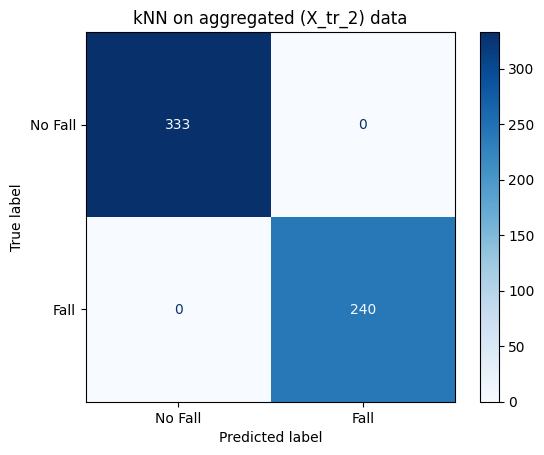

In [215]:
cm_knn_2 = confusion_matrix(y_tr_2, y_df2_knn_pred, labels=[0,1])
disp_knn_2 = ConfusionMatrixDisplay(confusion_matrix=cm_knn_2,display_labels=['No Fall', 'Fall'])
disp_knn2_cm = disp_knn_2.plot(cmap=plt.cm.Blues,values_format='g')
plt.title("kNN on aggregated (X_tr_2) data")
plt.show();

In [216]:
print(classification_report(y_tr_2, y_df2_knn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00       240

    accuracy                           1.00       573
   macro avg       1.00      1.00      1.00       573
weighted avg       1.00      1.00      1.00       573



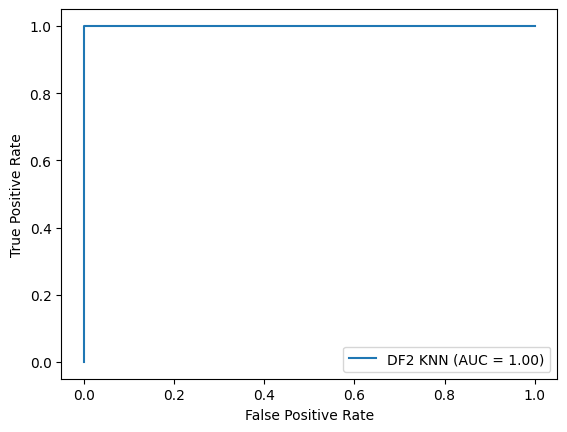

In [217]:
fpr, tpr, thresholds = roc_curve(y_tr_2, y_df2_knn_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='DF2 KNN')
display.plot()
plt.show()

## with XG boost

In [218]:
# default XG Boost on df_feat dataset

df2_XGboost = Pipeline(steps=[('ct2', CT_2),
                            ('xgb2', xgboost.XGBClassifier(random_state=24))])
df2_XGboost.fit(X_tr_2, y_tr_2)
begin = time.time()
y_df2_xgb_pred = df2_XGboost.predict(X_tr_2)
end = time.time()
df2_XGB_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {df2_XGB_time} seconds.
""")

[09:21:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The total time to predict for this model is 0.007 seconds.



In [219]:
df2_XGboost_scores = cross_validate(df2_XGboost, X_tr_2, y_tr_2, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

[09:21:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [220]:
df2_XGboost_results = results(df2_XGboost_scores)

In [221]:
print_results(df2_XGboost_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9739. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9625. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9758. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9685. 

    **********************************
    The mean fit time for this model is 0.1078 seconds.
    The mean score time for this model is 0.0075 seconds.
    


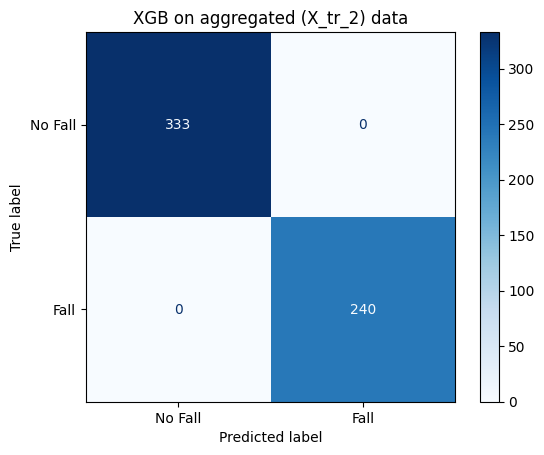

In [222]:
cm_xgb_2 = confusion_matrix(y_tr_2, y_df2_xgb_pred, labels=[0,1])
disp_xgb_2 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_2, display_labels=['No Fall', 'Fall'])
disp_xgb2_cm = disp_xgb_2.plot(cmap=plt.cm.Blues,values_format='g')
plt.title("XGB on aggregated (X_tr_2) data")
plt.show();

In [223]:
print(classification_report(y_tr_2, y_df2_xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00       240

    accuracy                           1.00       573
   macro avg       1.00      1.00      1.00       573
weighted avg       1.00      1.00      1.00       573



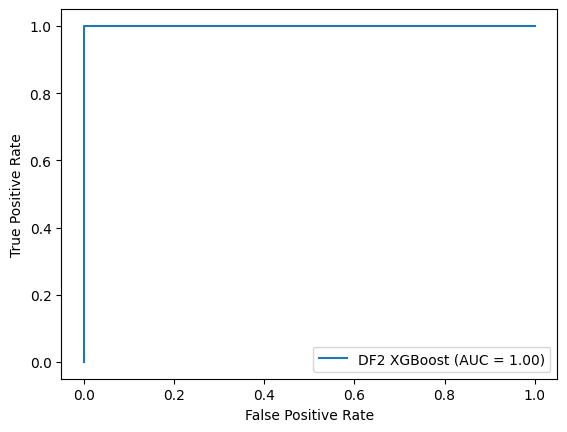

In [224]:
fpr, tpr, thresholds = roc_curve(y_tr_2, y_df2_xgb_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='DF2 XGBoost')
display.plot()
plt.show()

**Summary:** Both of these models are performing very well in terms of metrics and time.  However, the kNN model seems to have a clear edge on most metrics (see below for accuracy and recall), though not quite on time.  Since time is less of a concern in this model using aggregate data, we will use the kNN model on the df_feat test data (X_te_2 and y_te_2).  

In [225]:
# df2 knn accuracy
df2_knn_scores['test_accuracy'].mean()

0.9912738367658276

In [226]:
# df2 XG boost accuracy
df2_XGboost_scores['test_accuracy'].mean()

0.9738520213577422

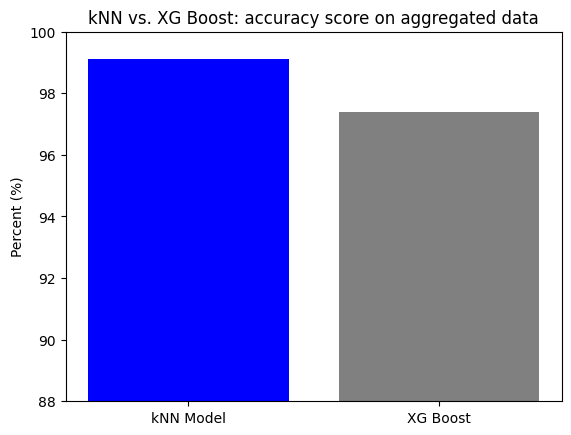

In [227]:
y_df2_acc_plot = [(df2_knn_scores['test_accuracy'].mean()*100), (df2_XGboost_scores['test_accuracy'].mean()*100)]
x_df2_acc_plot = ['kNN Model', 'XG Boost']
plt.bar(x = x_df2_acc_plot, height = y_df2_acc_plot, color=['blue', 'grey'])
plt.xticks(rotation=0, ha="center", rotation_mode='anchor')
plt.ylabel('Percent (%)')
plt.ylim(88, 100)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("kNN vs. XG Boost: accuracy score on aggregated data")
plt.savefig('images/knn_xgb_df_feat_acc.png', bbox_inches='tight', dpi=300)
plt.show;

In [228]:
# df2 knn recall
df2_knn_scores['test_recall'].mean()

0.9833333333333332

In [229]:
# df2 XG boost recall
df2_XGboost_scores['test_recall'].mean()

0.9625

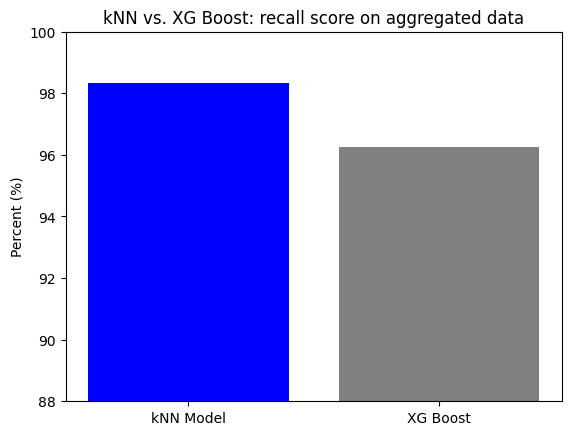

In [230]:
y_df2_rec_plot = [(df2_knn_scores['test_recall'].mean()*100), (df2_XGboost_scores['test_recall'].mean()*100)]
x_df2_rec_plot = ['kNN Model', 'XG Boost']
plt.bar(x = x_df2_rec_plot, height = y_df2_rec_plot, color=['blue', 'grey'])
plt.xticks(rotation=0, ha="center", rotation_mode='anchor')
plt.ylabel('Percent (%)')
plt.ylim(88, 100)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("kNN vs. XG Boost: recall score on aggregated data")
plt.savefig('images/knn_xgb_df_feat_rec.png', bbox_inches='tight', dpi=300)
plt.show;

<a id='knnfeat'></a>
### df_feat Test data
Using k Nearest Neighbors (the best model from prior GridSearch)

In [231]:
# instantiating with above settings

df2_knn_test = Pipeline(steps=[('ct2', CT_2),
                            ('knn2_test', KNeighborsClassifier(
                                metric='manhattan',
                            n_neighbors=1,
                            weights='uniform'))])
df2_knn_test.fit(X_te_2, y_te_2)
begin = time.time()
y_df2_knn_test_pred = df2_knn_test.predict(X_te_2)
end = time.time()
df2_knn_time_test = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {df2_knn_time_test} seconds.
""")


The total time to predict for this model is 0.0047 seconds.



In [232]:
df2_knn_test_scores = cross_validate(df2_knn_test, X_te_2, y_te_2, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

In [233]:
df2_knn_test_results = results(df2_knn_test_scores)

In [234]:
print_results(df2_knn_test_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9742. 

    The mean train recall score is 1.0.
    The mean test recall score is 0.9895. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.9619. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.9746. 

    **********************************
    The mean fit time for this model is 0.0066 seconds.
    The mean score time for this model is 0.0062 seconds.
    


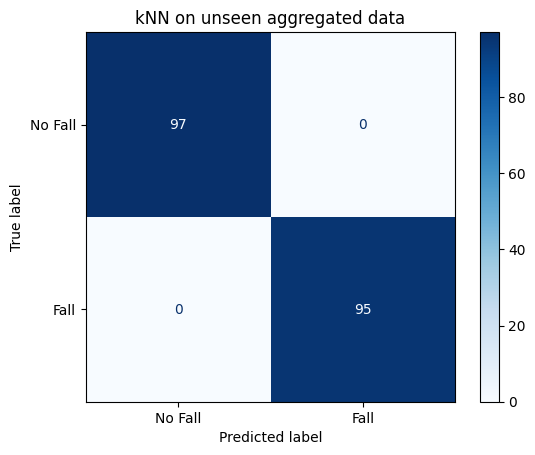

In [235]:
cm_knn_final = confusion_matrix(y_te_2, y_df2_knn_test_pred, labels=[0,1])
disp_knn_final = ConfusionMatrixDisplay(confusion_matrix=cm_knn_final, display_labels=['No Fall', 'Fall'])
disp_knn_final_cm = disp_knn_final.plot(cmap=plt.cm.Blues,values_format='g')
plt.title("kNN on unseen aggregated data")
plt.savefig('images/knn_agg_conf_matrix.png', bbox_inches='tight', dpi=300)
plt.show();

In [236]:
y_te_2.value_counts()

0    97
1    95
Name: Fall, dtype: int64

In [237]:
print(classification_report(y_te_2, y_df2_knn_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        95

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



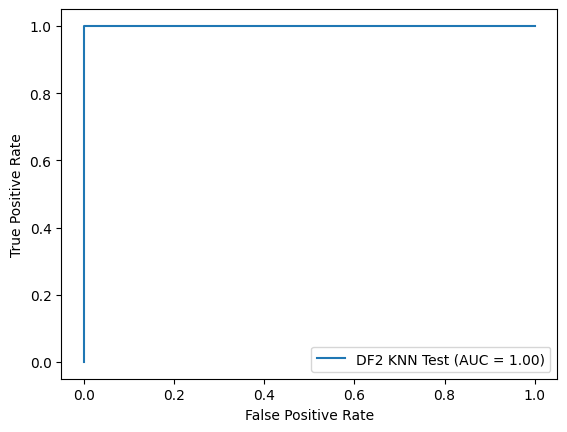

In [238]:
fpr, tpr, thresholds = roc_curve(y_te_2, y_df2_knn_test_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='DF2 KNN Test')
display.plot()
plt.show()

**Summary:** for aggregated data, perhaps amassed in more of a time-lapse window, it may be more appropriate to use a k Nearest Neighbors algorithm.  The concern with using k Nearest Neighbors on the df_raw dataframe was the increased predict / scoring time required for 1 second interval data, but that's less of a concern if information is being transmitted less frequently and perhaps being aggregated and analyzed remotely.  

<a id='arcotest'></a>
# Separate ARCO Research Test Data folder

Final evaluation, now using the unseen test_dataset.zip files from ARCO's __[website](https://arcoresearch.com/2021/04/16/dataset-for-fall-detection/)__ using the best model (default XG Boost) from df_raw modeling

## Loading separate ARCO test_data

In [239]:
# ! unzip test_dataset.zip

In [240]:
# can replace this pathname with the full path to the folder locally
path_test = r'C:\Users\JonMc\Documents\Flatiron\Fall_Detection_Model\data\test_dataset' 

# Get the files from the path provided
files_test = Path(path_test).glob('*.csv') 

In [241]:
dfs_test = []
for f in files_test:
    data = pd.read_csv(f)
    # .stem is the method for pathlib objects to get the filename without the extension
    data['File'] = f.stem
    dfs_test.append(data)

In [242]:
# concatenating all 17 files into one dataframe
df_test = pd.concat(dfs_test, ignore_index=True)

In [243]:
df_test.shape

(6675, 10)

In [244]:
df_test.head()

,Feature Line,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Timestamp,Fall,File
0,0,0.188965,-2.758545,2.326172,-10.955224,178.574627,103.470149,1.132324e+06,1,Subject1
1,0,0.981689,-3.999512,0.450317,-21.641791,144.716418,206.097015,1.132335e+06,1,Subject1
2,0,-0.514038,-2.499146,-1.742432,184.171642,209.865672,221.507463,1.132355e+06,1,Subject1
3,0,-2.666138,-1.324951,-0.175293,176.156716,240.380597,53.074627,1.132376e+06,1,Subject1
4,0,-1.332886,0.920288,0.447388,244.507463,-109.119403,52.164179,1.132397e+06,1,Subject1


In [245]:
df_test['Fall'].value_counts()

1    3732
0    2943
Name: Fall, dtype: int64

These test folder files contain most of the same information as the df_raw files did.  However, they are **missing Pitch, Roll and Yaw data**.  How important are these features for the XG Boost model we intend to use?

## Feature importance

We will use XG Boost's .feature_importances_ to determine what features are most important for the XG Boosts classification of df_raw data

In [246]:
# using the final model from df_raw modeling, used on X_test, and .get_feature_names_out
XG_boost_test.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Acc(X)', 'Acc(Y)', 'Acc(Z)',
                                                   'Rot(X)', 'Rot(Y)', 'Rot(Z)',
                                                   'Pitch', 'Roll', 'Yaw']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['File'])])),
                ('xgb_test',
                 XGBClassifier(base_score=0.5, boo...
        

In [247]:
# creating an array of categorical variable names
CT.named_transformers_['subpipe_cat']['ohe'].get_feature_names()

array(['x0_Subject1-raw', 'x0_Subject10-raw', 'x0_Subject11-raw',
       'x0_Subject12-raw', 'x0_Subject13-raw', 'x0_Subject14-raw',
       'x0_Subject15-raw', 'x0_Subject16-raw', 'x0_Subject17-raw',
       'x0_Subject2-raw', 'x0_Subject3-raw', 'x0_Subject4-raw',
       'x0_Subject5-raw', 'x0_Subject6-raw', 'x0_Subject7-raw',
       'x0_Subject8-raw', 'x0_Subject9-raw'], dtype=object)

In [248]:
# creating an intitial list of feature names based on numeric features
all_feature_names = num_feats.copy()

In [249]:
# extending that list with the categorical feature names
all_feature_names.extend(list(CT.named_transformers_['subpipe_cat']['ohe'].get_feature_names()))

In [250]:
# array of feature_importances_
XG_boost_test['xgb_test'].feature_importances_

array([0.0095341 , 0.01194969, 0.02484648, 0.00961888, 0.0224641 ,
       0.0768692 , 0.05236392, 0.49162236, 0.03035896, 0.02141742,
       0.02505719, 0.04031874, 0.01336914, 0.01238386, 0.00846492,
       0.02754278, 0.00800027, 0.02239779, 0.02666807, 0.01133379,
       0.00303494, 0.01153741, 0.        , 0.01986001, 0.0015317 ,
       0.01745422], dtype=float32)

In [251]:
# list of tuples associating feature names with their importances
feat_import = [(name, score) 
                   for name, score 
                       in zip(all_feature_names, XG_boost_test['xgb_test'].feature_importances_)]
feat_import

[('Acc(X)', 0.009534102),
 ('Acc(Y)', 0.011949688),
 ('Acc(Z)', 0.024846485),
 ('Rot(X)', 0.0096188765),
 ('Rot(Y)', 0.022464104),
 ('Rot(Z)', 0.076869205),
 ('Pitch', 0.052363917),
 ('Roll', 0.49162236),
 ('Yaw', 0.030358965),
 ('x0_Subject1-raw', 0.021417417),
 ('x0_Subject10-raw', 0.025057195),
 ('x0_Subject11-raw', 0.04031874),
 ('x0_Subject12-raw', 0.013369138),
 ('x0_Subject13-raw', 0.012383859),
 ('x0_Subject14-raw', 0.008464916),
 ('x0_Subject15-raw', 0.027542781),
 ('x0_Subject16-raw', 0.008000272),
 ('x0_Subject17-raw', 0.022397792),
 ('x0_Subject2-raw', 0.02666807),
 ('x0_Subject3-raw', 0.011333789),
 ('x0_Subject4-raw', 0.0030349365),
 ('x0_Subject5-raw', 0.011537414),
 ('x0_Subject6-raw', 0.0),
 ('x0_Subject7-raw', 0.019860012),
 ('x0_Subject8-raw', 0.0015316966),
 ('x0_Subject9-raw', 0.01745422)]

In [252]:
# sorting those feature importances in descending order
feat_import.sort(key= lambda x: x[1], reverse=True)

In [253]:
feat_import

[('Roll', 0.49162236),
 ('Rot(Z)', 0.076869205),
 ('Pitch', 0.052363917),
 ('x0_Subject11-raw', 0.04031874),
 ('Yaw', 0.030358965),
 ('x0_Subject15-raw', 0.027542781),
 ('x0_Subject2-raw', 0.02666807),
 ('x0_Subject10-raw', 0.025057195),
 ('Acc(Z)', 0.024846485),
 ('Rot(Y)', 0.022464104),
 ('x0_Subject17-raw', 0.022397792),
 ('x0_Subject1-raw', 0.021417417),
 ('x0_Subject7-raw', 0.019860012),
 ('x0_Subject9-raw', 0.01745422),
 ('x0_Subject12-raw', 0.013369138),
 ('x0_Subject13-raw', 0.012383859),
 ('Acc(Y)', 0.011949688),
 ('x0_Subject5-raw', 0.011537414),
 ('x0_Subject3-raw', 0.011333789),
 ('Rot(X)', 0.0096188765),
 ('Acc(X)', 0.009534102),
 ('x0_Subject14-raw', 0.008464916),
 ('x0_Subject16-raw', 0.008000272),
 ('x0_Subject4-raw', 0.0030349365),
 ('x0_Subject8-raw', 0.0015316966),
 ('x0_Subject6-raw', 0.0)]

## Visual of feature_importances_ from XG_boost_test 

In [254]:
# list of top 10 feature names
feat_plot_list = [x[0] for x in feat_import]
feat_plot_list[:10]

['Roll',
 'Rot(Z)',
 'Pitch',
 'x0_Subject11-raw',
 'Yaw',
 'x0_Subject15-raw',
 'x0_Subject2-raw',
 'x0_Subject10-raw',
 'Acc(Z)',
 'Rot(Y)']

In [255]:
# list of top 10 feature values
feat_plot_values = [x[1] for x in feat_import]
feat_plot_values[:10]

[0.49162236,
 0.076869205,
 0.052363917,
 0.04031874,
 0.030358965,
 0.027542781,
 0.02666807,
 0.025057195,
 0.024846485,
 0.022464104]

In [256]:
# separate, cleaner list of the top 10 feature names for plotting
y_fi_plot = ['Roll', 'Rot(Z)', 'Pitch', 'Subject 11', 'Yaw', 
             'Subject 15', 'Subject 2', 'Subject 10', 'Acc(Z)', 'Rot(Y)']

In [257]:
# multiplying feature importance values for a plot that's easier to read
# on the x axis

x_fi_plot = list(np.array(feat_plot_values[:10]) *10)

In [258]:
# reversing y values
y_rev= invertList(y_fi_plot)

In [259]:
# reversing x values
x_rev = invertList(x_fi_plot)

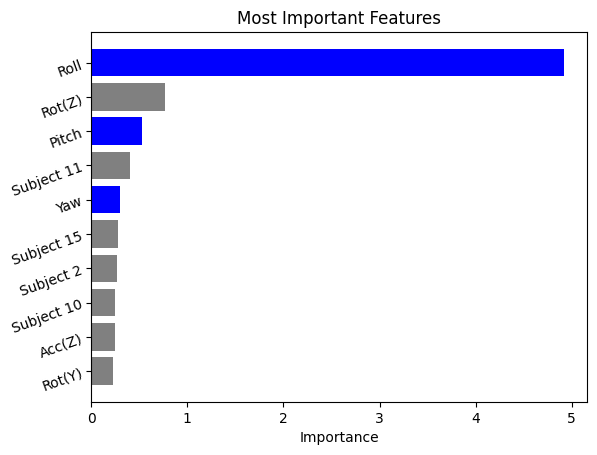

In [260]:
color = ['grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'grey',
         'blue', 'grey', 'blue']

plt.barh(y = y_rev, width = x_rev, color=color)
plt.xticks(rotation=0, ha="center", rotation_mode='anchor')
plt.yticks(rotation=20, ha="right", rotation_mode='anchor')
plt.xlabel("Importance")
plt.title("Most Important Features")
plt.savefig('images/feat_import_plot.png', bbox_inches='tight', dpi=300)
plt.show;

Unfortunately, those 3 variables are quite important to my best chosen model.  Especially 'Roll'.  Oh well.  It's not clear why their 'test' data is missing this information, but I will choose to proceed with my best model for df_raw data (XG Boost default).

## Processing the ARCO test data (df_test) in the same manner as df_raw

In [261]:
# dropping 'Feature Line' and 'Timestamp'

df_test.drop(['Feature Line', 'Timestamp'], axis=1, inplace=True)

In [262]:
df_test.head()

,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),Fall,File
0,0.188965,-2.758545,2.326172,-10.955224,178.574627,103.470149,1,Subject1
1,0.981689,-3.999512,0.450317,-21.641791,144.716418,206.097015,1,Subject1
2,-0.514038,-2.499146,-1.742432,184.171642,209.865672,221.507463,1,Subject1
3,-2.666138,-1.324951,-0.175293,176.156716,240.380597,53.074627,1,Subject1
4,-1.332886,0.920288,0.447388,244.507463,-109.119403,52.164179,1,Subject1


In [263]:
df_test.shape

(6675, 8)

In [264]:
# definining X & y for final model
X_test_df = df_test.drop(['Fall'], axis=1)
y_test_df = df_test['Fall']

In [265]:
X_test_df.head()

,Acc(X),Acc(Y),Acc(Z),Rot(X),Rot(Y),Rot(Z),File
0,0.188965,-2.758545,2.326172,-10.955224,178.574627,103.470149,Subject1
1,0.981689,-3.999512,0.450317,-21.641791,144.716418,206.097015,Subject1
2,-0.514038,-2.499146,-1.742432,184.171642,209.865672,221.507463,Subject1
3,-2.666138,-1.324951,-0.175293,176.156716,240.380597,53.074627,Subject1
4,-1.332886,0.920288,0.447388,244.507463,-109.119403,52.164179,Subject1


### Using XG Boost Model on df_test

I need new pipelines and new ColumnTransformer due to the difference in columns / features from df_raw (the lack of 'Roll', 'Pitch', and 'Yaw')

In [266]:
# new pipeline
subpipe_num_final = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat_final = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [267]:
# new categories to consider
num_feats_final = list(X_test_df.select_dtypes(include=['number']).columns)
cat_feats_final = ['File']

In [268]:
CT_final = ColumnTransformer(transformers=[('subpipe_num_final', subpipe_num_final, num_feats_final),
                                     ('subpipe_cat_final', subpipe_cat_final, cat_feats_final)],
                                     remainder='passthrough')

In [269]:
# default XG Boost still

XG_boost_final = Pipeline(steps=[('ct_final', CT_final),
                            ('xgb_final', xgboost.XGBClassifier(random_state=24))])

XG_boost_final.fit(X_test_df, y_test_df)
begin = time.time()
y_XGB_final_pred = XG_boost_final.predict(X_test_df)
end = time.time()
XG_boost_final_time = (round(end - begin, 4))
print(f"""
The total time to predict for this model is {XG_boost_final_time} seconds.
""")

[09:21:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The total time to predict for this model is 0.0241 seconds.



In [270]:
XG_boost_final_scores = cross_validate(XG_boost_final, X_test_df, y_test_df, cv=5,
                                scoring=('accuracy', 'recall', 'precision', 'f1'),
                                return_train_score=True)

[09:21:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:21:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [271]:
XG_boost_final_results = results(XG_boost_final_scores)

In [272]:
print_results(XG_boost_final_results)


    The mean train accuracy score is 1.0.
    The mean test accuracy score is 0.9023. 

    The mean train recall score is 0.9999.
    The mean test recall score is 0.9126. 

    The mean train precision score is 1.0.
    The mean test precision score is 0.914. 

    The mean train f1 score is 1.0.
    The mean test f1 score is 0.913. 

    **********************************
    The mean fit time for this model is 0.8512 seconds.
    The mean score time for this model is 0.0134 seconds.
    


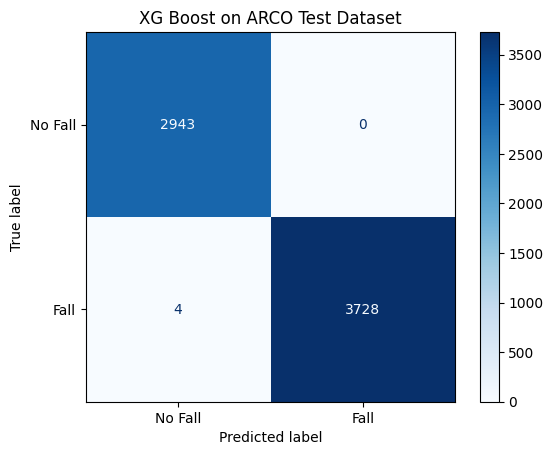

In [273]:
cm_xgb_final = confusion_matrix(y_test_df, y_XGB_final_pred, labels=[0,1])
disp_xgb_final = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_final,display_labels=['No Fall', 'Fall'])
disp_xgb_cm = disp_xgb_final.plot(cmap=plt.cm.Blues,values_format='g')
plt.title("XG Boost on ARCO Test Dataset")
plt.savefig('images/xgb_final_conf_matrix.png', bbox_inches='tight', dpi=300)
plt.show();

In [274]:
# definitely mis-classified 4 falls

y_test_df.value_counts()

1    3732
0    2943
Name: Fall, dtype: int64

In [275]:
print(classification_report(y_test_df, y_XGB_final_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2943
           1       1.00      1.00      1.00      3732

    accuracy                           1.00      6675
   macro avg       1.00      1.00      1.00      6675
weighted avg       1.00      1.00      1.00      6675



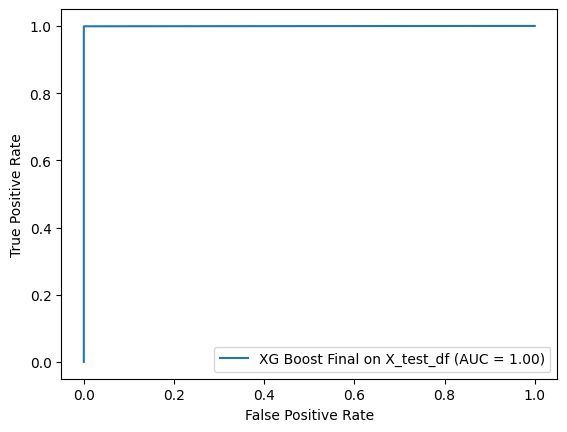

In [276]:
fpr, tpr, thresholds = roc_curve(y_test_df, y_XGB_final_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='XG Boost Final on X_test_df')
display.plot()
plt.show()

**Summary:**  The final XG Boost model unfortunately had 4 false negatives, which in real-life terms would mean 4 falls that actually occurred and were not reported.  This could be catastrophic to the parties involved, either in terms of worsening injury, or potentially even a fatality.  One explanation for the decreased performance of this XG Boost model is the lack of pitch, roll, and yaw data that was included in the df_raw files and which all previous models have been using in their calculations.  We saw above how important those 3 features are to the XG boost model selected.  Considering *how* important that data was, as described by .feature_importances_, it's actually pretty impressive there were only 4 incorrect predictions in the entire dataset (a 0.0006% error).  

In [277]:
4 / len(df_test)

0.000599250936329588

<a id='limit'></a>
## Limitations

This modeling process overall went very smoothly, starting with clean datasets and a clear target in 2 of 3 datasets.  That being said, a clearer explanation of how data was aggregated in the "fall-dataset-features" folder may have been helpful, as well as a better explanation of how to best associate the "fall-dataset-all" folder to the other datasets based on "Timestamp".  For now, I had to leave the "fall-dataset-all" folder out of my supervised modeling approaches.  

Another limitation to the final modeling, using the separately released "test_dataset" folder, was the fact that three important features ("Roll", "Pitch", and "Yaw") were missing from the files.  To minimize the risk of any data leakage as much as possible, I had not even opened those files until the end of my modeling iterations, and then realized the discrepancy between the "test_dataset" and the "fall-dataset-raw" files I had been using thus far.  

<a id='summary'></a>
# Summary

As established at the beginning of this presentation, and as the director of CMS's Office of Enterprise Data & Analytics well knows, falls are a major concern for aging Americans, in terms of potential injuries / fatalities, cost of care, and overall quality of life.  The portion of the population age 65 and over is expected to continue to increase, as are the total number of falls and the injuries related to those falls.  As a physical therapist who has worked in a variety of settings, I believe there is great value in having real-time recognition of a fall event so family & emergency personnel can receive immediate notice and the person who has sustained a fall can receive prompt medical attention.  Perhaps if such a system existed in the United States, CMS may find there is a significant impact for cost-savings and quality of life.  

In addition to the original research related to this publicly-available ARCO dataset, my analysis provides further proof that data from a body-worn motion sensor, combined with a machine learning classification model such as XG Boost, can yield accurate and actionable information that would improve user safety and reduce costly medical complications related to falls.  There were many types of models to consider with this classification problem, and through the use of a variety of metrics (accuracy, recall, precision, and F1 score), as well as assessment through confusion matrices and ROC curves, hopefully I presented a logical progression through the various models to reach the best conclusion. 

Also, as an alternative, if communicating real-time data is not ideal or feasible, then a separate k Nearest Neighbors model, using aggregated sensor data in a time-lapse window can also help verify accurate diagnosis that a fall has occurred and initiate emergent medical management for someone who has sustained a fall.

Thanks for reading :)

If you have any questions, feel free to reach out: jonmccaffrey524@gmail.com 